Graph saved as citation_relationship_20250127_212450.png


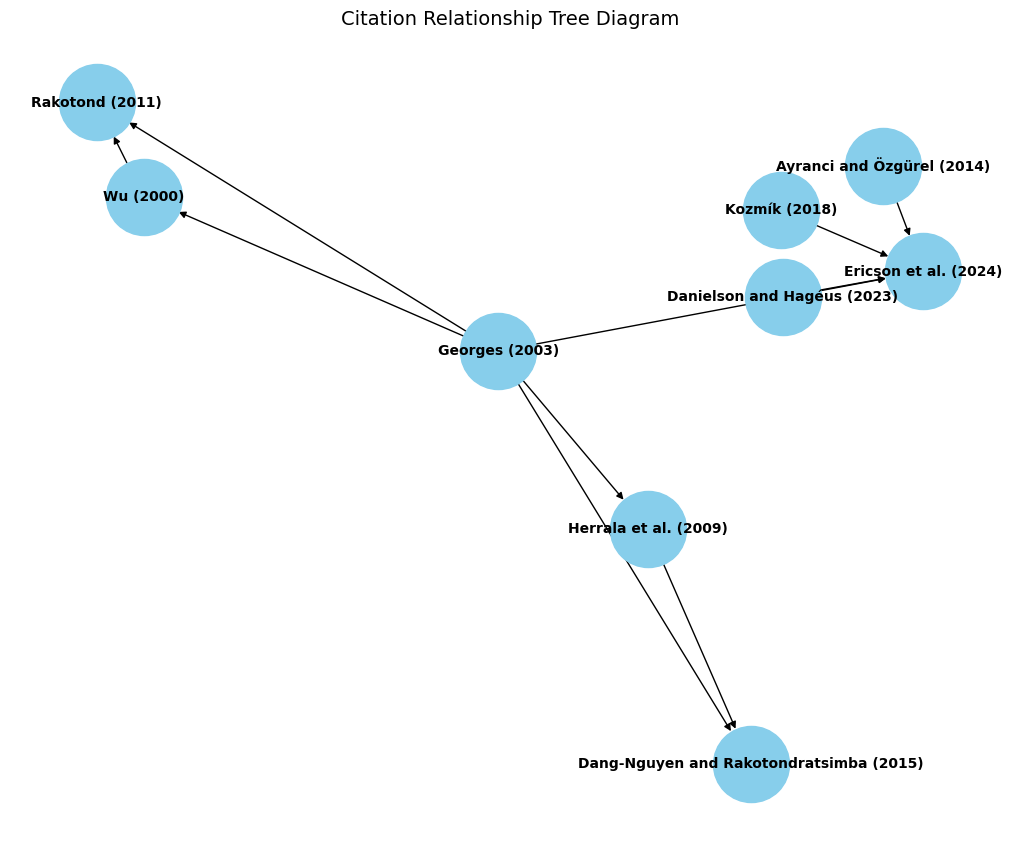

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the papers and their citations
papers = [
    ("Ericson et al. (2024)", ["Georges (2003)", "Danielson and Hagéus (2023)", "Kozmík (2018)", "Ayranci and Özgürel (2014)"]),
    ("Georges (2003)", []),
    ("Danielson and Hagéus (2023)", []),
    ("Kozmík (2018)", []),
    ("Ayranci and Özgürel (2014)", []),
    ("Herrala et al. (2009)", ["Georges (2003)"]),
    ("Dang-Nguyen and Rakotondratsimba (2015)", ["Georges (2003)", "Herrala et al. (2009)"]),
    ("Wu (2000)", ["Georges (2003)"]),
    ("Rakotond (2011)", ["Georges (2003)", "Wu (2000)"])
]

# Add nodes and edges to the graph
for paper, citations in papers:
    for citation in citations:
        G.add_edge(citation, paper)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for a nice layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.title("Citation Relationship Tree Diagram", fontsize=14)


import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)
# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")

plt.show()


Graph saved as citation_relationship_20250127_212510.png


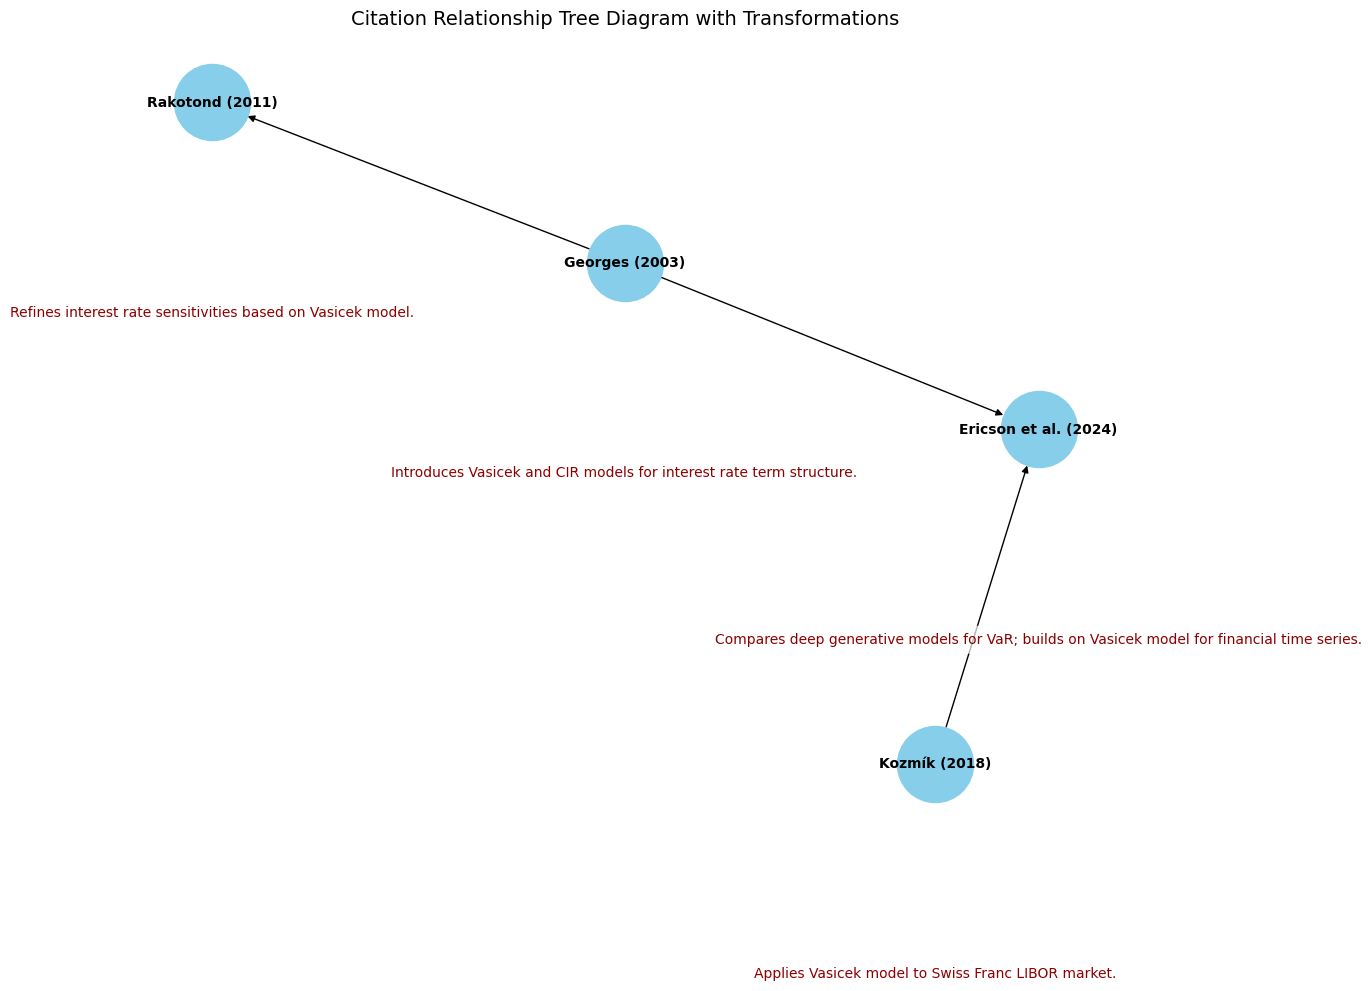

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the papers and their citations, including transformations/steps
papers = [
    ("Ericson et al. (2024)", ["Georges (2003)", "Kozmík (2018)"], "Compares deep generative models for VaR; builds on Vasicek model for financial time series."),
    ("Georges (2003)", [], "Introduces Vasicek and CIR models for interest rate term structure."),
    ("Kozmík (2018)", [], "Applies Vasicek model to Swiss Franc LIBOR market."),
    ("Rakotond (2011)", ["Georges (2003)"], "Refines interest rate sensitivities based on Vasicek model."),
]

# Add nodes and edges to the graph with transformations
for paper, citations, transformation in papers:
    for citation in citations:
        G.add_edge(citation, paper, label=transformation)
    G.nodes[paper]['transformation'] = transformation

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for a nice layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)

# Add annotations for transformations
for paper in G.nodes:
    transformation = G.nodes[paper].get('transformation', '')
    if transformation:
        x, y = pos[paper]
        plt.text(x, y-0.1, transformation, fontsize=10, ha='center', color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

plt.title("Citation Relationship Tree Diagram with Transformations", fontsize=14)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


Data downloaded successfully.
Estimated Parameters:
Kappa (mean reversion speed): 6.254991206070167
Theta (long-term mean): 2.881350151353567
Sigma (volatility): 40.91905530780289


/tmp/ipykernel_9533/3414834213.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r0 = rates[-1]  # Use the last observed rate as the starting point


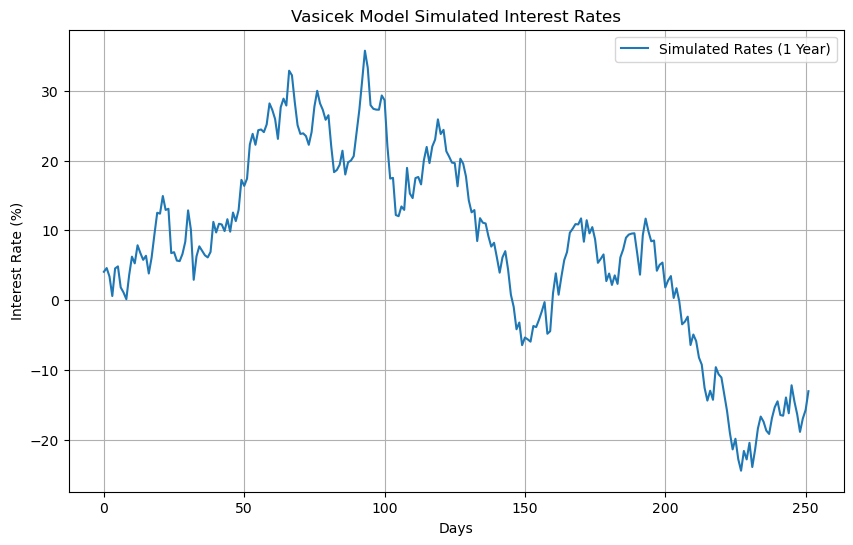

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.optimize import minimize
from datetime import datetime

# Step 1: Download interest rate data (10-year Treasury yield from FRED)
start = datetime(2000, 1, 1)
end = datetime(2024, 1, 1)
data = web.DataReader('GS10', 'fred', start, end)

# Check if the data was downloaded successfully
if not data.empty:
    rates = data['GS10'].dropna()
    print("Data downloaded successfully.")
else:
    raise ValueError("Error: Data is missing or improperly formatted.")

# Step 2: Define the Vasicek model's log-likelihood function to estimate parameters
def vasicek_likelihood(params, rates):
    kappa, theta, sigma = params
    dt = 1 / 252  # Assume daily frequency (252 trading days per year)
    
    # Calculate the daily log returns (difference)
    dr = np.diff(rates)
    r = rates[:-1]
    
    # Likelihood for each step in the process
    log_likelihood = -np.sum(np.log(0.5 * np.pi * sigma**2 * dt)) - np.sum(
        (dr - kappa * (theta - r) * dt)**2 / (2 * sigma**2 * dt)
    )
    return -log_likelihood  # Minimize negative log-likelihood

# Step 3: Estimate the Vasicek model parameters (kappa, theta, sigma)
initial_guess = [0.1, np.mean(rates), 0.01]
result = minimize(vasicek_likelihood, initial_guess, args=(rates,))
kappa, theta, sigma = result.x

print(f"Estimated Parameters:")
print(f"Kappa (mean reversion speed): {kappa}")
print(f"Theta (long-term mean): {theta}")
print(f"Sigma (volatility): {sigma}")

# Step 4: Simulate future interest rates using the fitted Vasicek model
def simulate_vasicek(r0, kappa, theta, sigma, T, N):
    dt = T / N
    rates_sim = np.zeros(N)
    rates_sim[0] = r0
    
    for i in range(1, N):
        dr = kappa * (theta - rates_sim[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates_sim[i] = rates_sim[i-1] + dr
    return rates_sim

# Simulate future 1-year interest rates (252 trading days)
r0 = rates[-1]  # Use the last observed rate as the starting point
simulated_rates = simulate_vasicek(r0, kappa, theta, sigma, T=1, N=252)

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 252), simulated_rates, label='Simulated Rates (1 Year)')
plt.title('Vasicek Model Simulated Interest Rates')
plt.xlabel('Days')
plt.ylabel('Interest Rate (%)')
plt.grid(True)
plt.legend()
plt.show()


In [4]:
# !pip install pandas_datareader

In [5]:
# !pip install yfinance

Epoch [0/5000] | D Loss: 1.3942 | G Loss: 0.7533
Epoch [1000/5000] | D Loss: 1.3835 | G Loss: 0.6942
Epoch [2000/5000] | D Loss: 1.3863 | G Loss: 0.6931
Epoch [3000/5000] | D Loss: 1.3863 | G Loss: 0.6929
Epoch [4000/5000] | D Loss: 1.3863 | G Loss: 0.6928
Graph saved as citation_relationship_20250127_212534.png


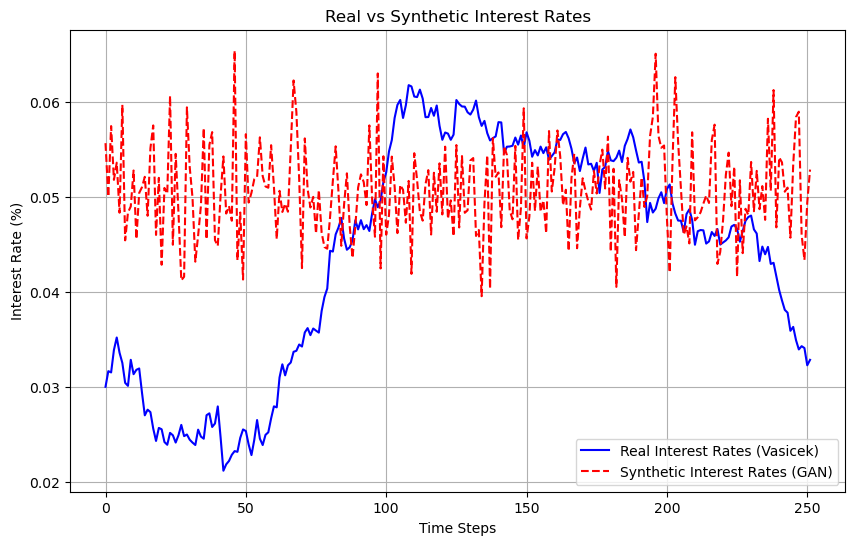

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define the GAN Model (Generator and Discriminator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )

    def forward(self, z):
        return self.fc(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train GAN
def train_gan(real_data, num_epochs=5000, batch_size=64):
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    for epoch in range(num_epochs):
        # Train Discriminator
        discriminator.zero_grad()
        real_inputs = torch.tensor(real_data[np.random.randint(0, len(real_data), batch_size)], dtype=torch.float32).view(-1, 1)
        real_outputs = discriminator(real_inputs)
        real_loss = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, 100)  # Random noise for generator
        fake_inputs = generator(z)
        fake_outputs = discriminator(fake_inputs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_inputs)
        g_loss = criterion(fake_outputs, real_labels)  # Fool the Discriminator
        g_loss.backward()
        optimizer_g.step()

        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate Synthetic Interest Rate Data using the trained Generator
def generate_synthetic_data(num_samples=252):
    z = torch.randn(num_samples, 100)
    synthetic_data = generator(z).detach().numpy()
    return synthetic_data.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Train GAN on the real interest rate data
train_gan(real_rates)

# Generate synthetic data using the trained GAN
synthetic_rates = generate_synthetic_data()

# Plot Real vs Synthetic Interest Rates
plt.figure(figsize=(10, 6))
plt.plot(real_rates, label="Real Interest Rates (Vasicek)", color='blue')
plt.plot(synthetic_rates, label="Synthetic Interest Rates (GAN)", color='red', linestyle='dashed')
plt.title('Real vs Synthetic Interest Rates')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


GAN-generated last rate: 0.0037331972271203995


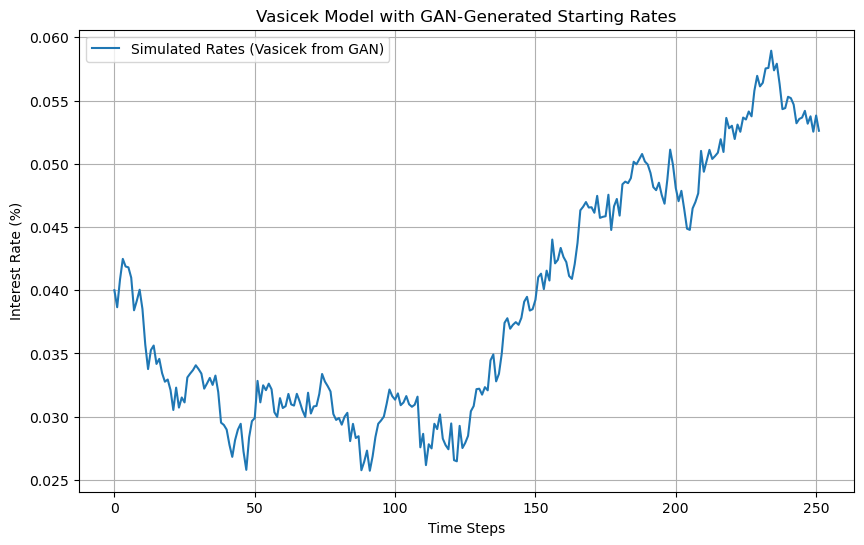

In [28]:
# Check GAN output range and adjust accordingly
print(f"GAN-generated last rate: {r0_from_gan}")

# Ensure that the starting rate is in the expected range (e.g., around 4%)
if r0_from_gan < 0.01:  # If GAN generated too low, set to a reasonable value like 4%
    r0_from_gan = 0.04  # Example: Set to 4%

# Simulate future interest rates using the Vasicek model with adjusted r0
simulated_rates_from_gan = simulate_vasicek_from_gan_input(r0=r0_from_gan)

# Check the output of the simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_rates_from_gan, label="Simulated Rates (Vasicek from GAN)")
plt.title('Vasicek Model with GAN-Generated Starting Rates')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


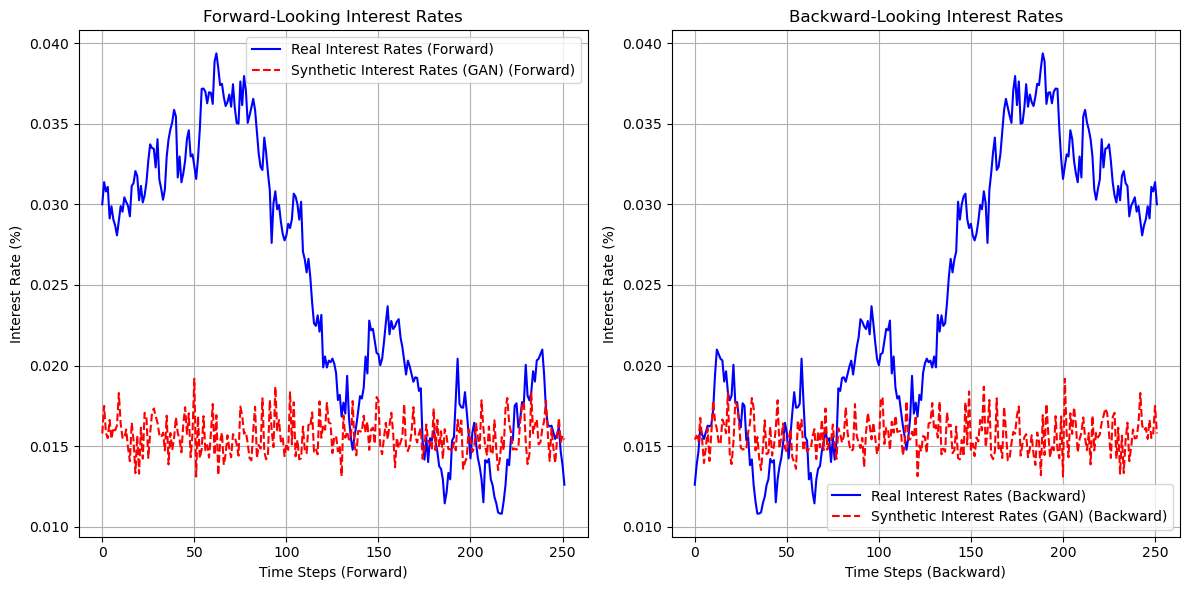

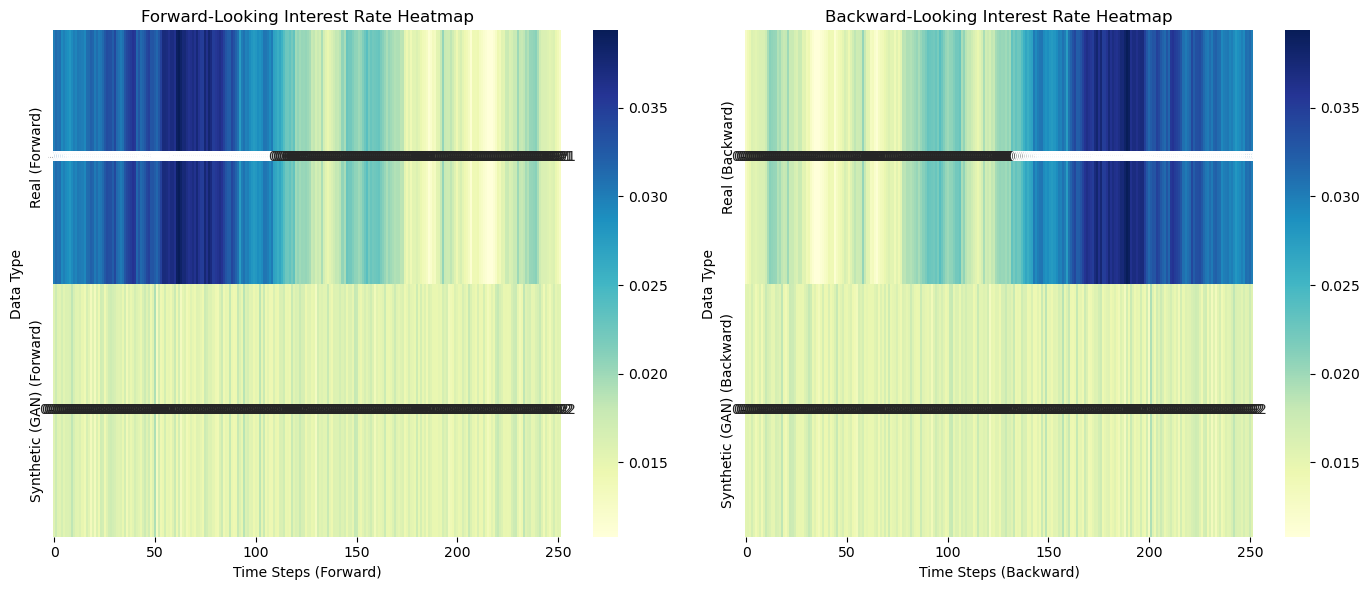

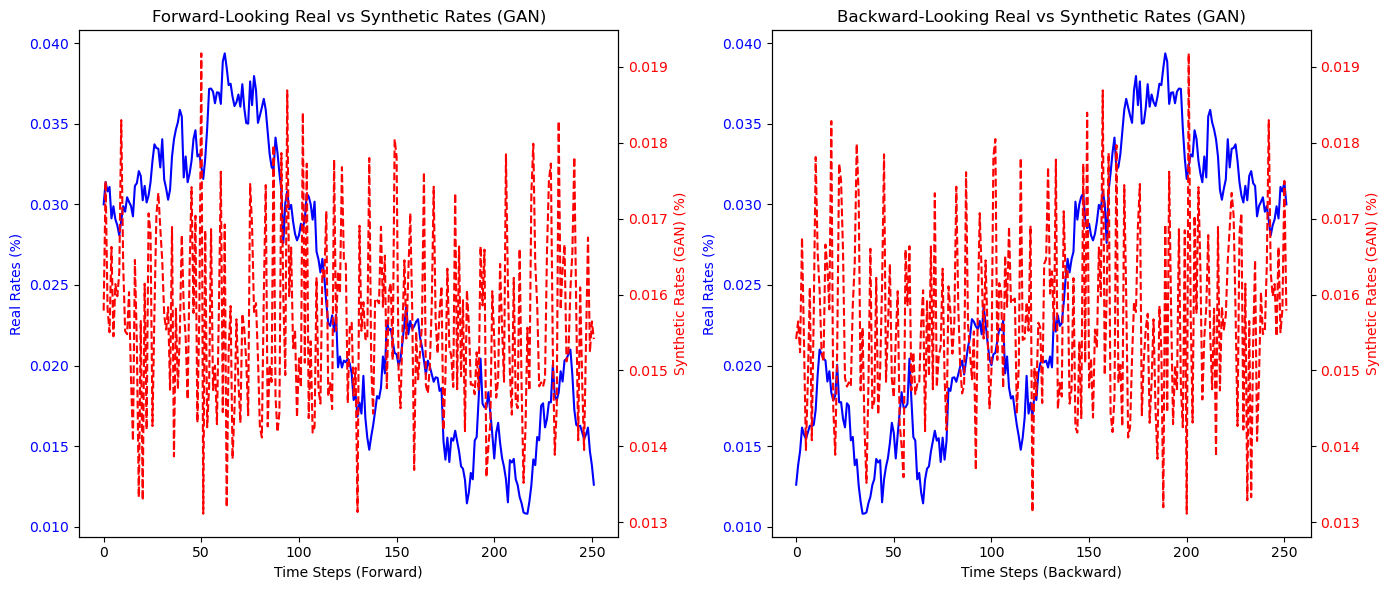

In [8]:
import seaborn as sns  # Add this import statement

# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# Forward-Looking Data (Same as original data)
real_rates_forward = real_rates
synthetic_rates_forward = synthetic_rates

# 1. **Forward-Looking vs Backward-Looking Comparison**
def plot_forward_backward_comparison():
    plt.figure(figsize=(12, 6))
    
    # Forward-Looking Plot
    plt.subplot(1, 2, 1)
    plt.plot(real_rates_forward, label="Real Interest Rates (Forward)", color='blue')
    plt.plot(synthetic_rates_forward, label="Synthetic Interest Rates (GAN) (Forward)", color='red', linestyle='dashed')
    plt.title('Forward-Looking Interest Rates')
    plt.xlabel('Time Steps (Forward)')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.grid(True)

    # Backward-Looking Plot
    plt.subplot(1, 2, 2)
    plt.plot(real_rates_backward, label="Real Interest Rates (Backward)", color='blue')
    plt.plot(synthetic_rates_backward, label="Synthetic Interest Rates (GAN) (Backward)", color='red', linestyle='dashed')
    plt.title('Backward-Looking Interest Rates')
    plt.xlabel('Time Steps (Backward)')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 2. **Heatmap for Forward and Backward Data**
def plot_heatmap_comparison():
    # Create a 2D array for the heatmap (interest rates for both forward and backward)
    data_forward = np.array([real_rates_forward, synthetic_rates_forward])
    data_backward = np.array([real_rates_backward, synthetic_rates_backward])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Forward Heatmap
    sns.heatmap(data_forward, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, xticklabels=50, yticklabels=["Real (Forward)", "Synthetic (GAN) (Forward)"], ax=axes[0])
    axes[0].set_title('Forward-Looking Interest Rate Heatmap')
    axes[0].set_xlabel('Time Steps (Forward)')
    axes[0].set_ylabel('Data Type')

    # Backward Heatmap
    sns.heatmap(data_backward, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, xticklabels=50, yticklabels=["Real (Backward)", "Synthetic (GAN) (Backward)"], ax=axes[1])
    axes[1].set_title('Backward-Looking Interest Rate Heatmap')
    axes[1].set_xlabel('Time Steps (Backward)')
    axes[1].set_ylabel('Data Type')

    plt.tight_layout()
    plt.show()

# 3. **Dual-Axis Plot for Forward and Backward Data**
def plot_dual_axis_comparison():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Forward Dual-Axis Plot
    ax1 = axes[0]
    ax1.plot(real_rates_forward, color='blue', label='Real Interest Rates (Forward)')
    ax1.set_xlabel('Time Steps (Forward)')
    ax1.set_ylabel('Real Rates (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(synthetic_rates_forward, color='red', linestyle='dashed', label='Synthetic Interest Rates (GAN) (Forward)')
    ax2.set_ylabel('Synthetic Rates (GAN) (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title('Forward-Looking Real vs Synthetic Rates (GAN)')

    # Backward Dual-Axis Plot
    ax1 = axes[1]
    ax1.plot(real_rates_backward, color='blue', label='Real Interest Rates (Backward)')
    ax1.set_xlabel('Time Steps (Backward)')
    ax1.set_ylabel('Real Rates (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(synthetic_rates_backward, color='red', linestyle='dashed', label='Synthetic Interest Rates (GAN) (Backward)')
    ax2.set_ylabel('Synthetic Rates (GAN) (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title('Backward-Looking Real vs Synthetic Rates (GAN)')

    plt.tight_layout()
    plt.show()

# Plot all comparisons: Forward vs Backward
plot_forward_backward_comparison()
plot_heatmap_comparison()
plot_dual_axis_comparison()


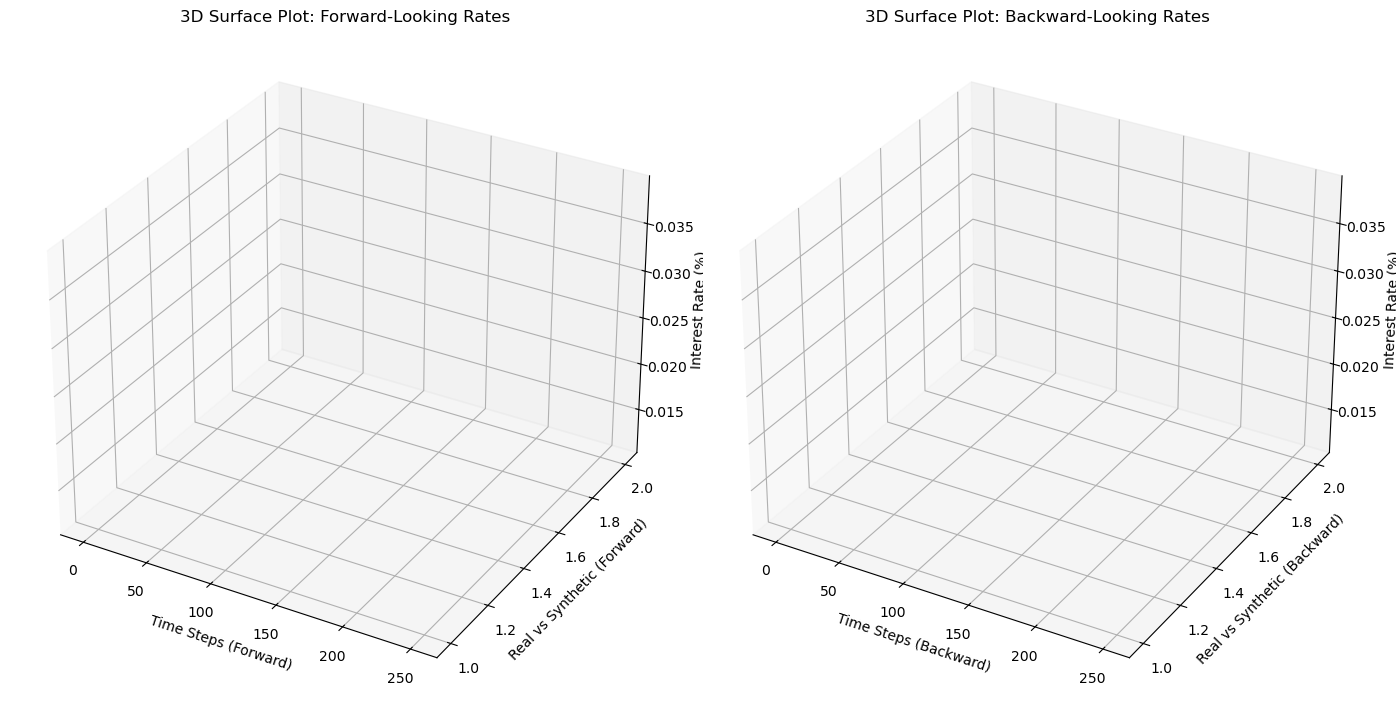

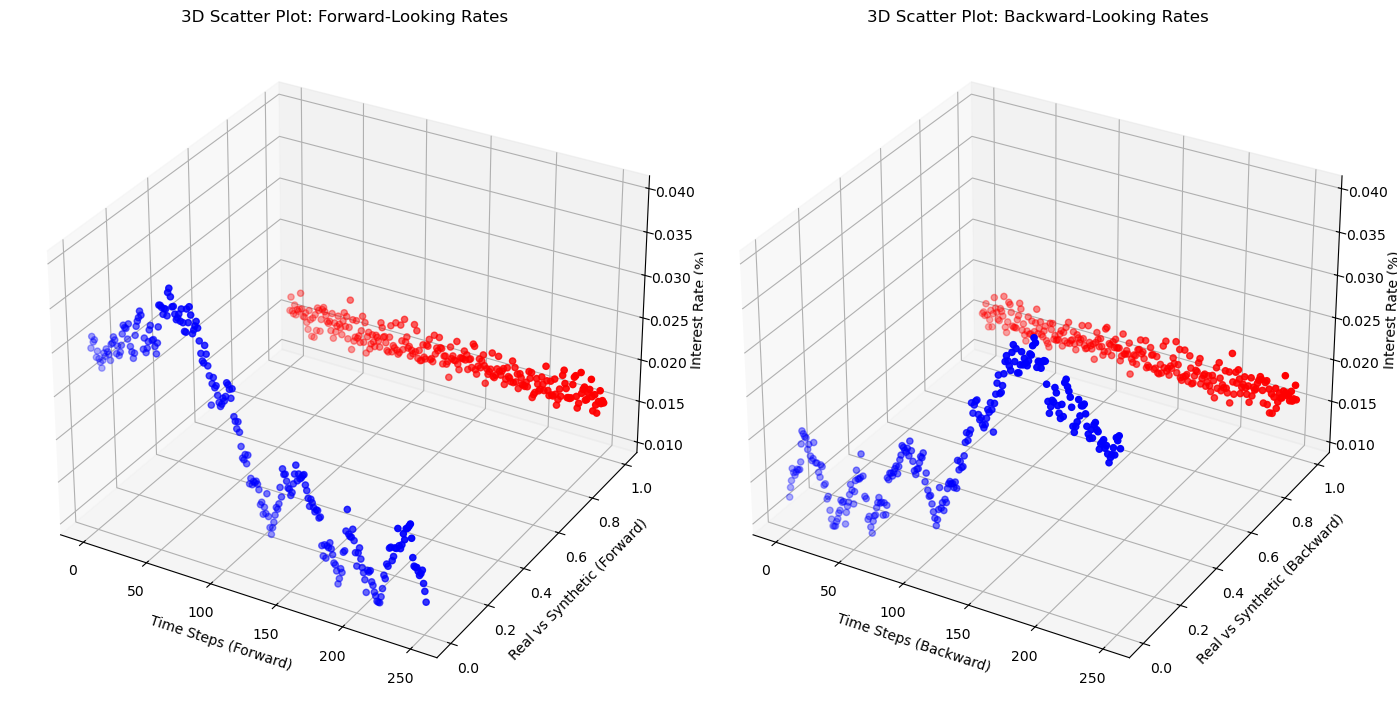

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# 4. **3D Surface Plot for Forward and Backward Comparison**
def plot_3d_surface_comparison():
    fig = plt.figure(figsize=(14, 7))
    
    # Create a 3D subplot for forward-looking data
    ax1 = fig.add_subplot(121, projection='3d')
    x = np.arange(len(real_rates_forward))
    y = np.ones_like(x)  # Just a dummy y-axis
    z_real = real_rates_forward
    z_synthetic = synthetic_rates_forward
    
    # Convert z values to 2D (repeat them along the y-axis)
    X, Y = np.meshgrid(x, y)  # Create mesh grid for 3D surface plotting
    Z_real = np.tile(z_real, (len(y), 1))  # Convert 1D to 2D for surface plot
    Z_synthetic = np.tile(z_synthetic, (len(y), 1))  # Similarly for synthetic

    ax1.plot_surface(X, Y, Z_real, color='blue', alpha=0.6, label="Real Rates (Forward)")
    ax1.plot_surface(X, Y + 1, Z_synthetic, color='red', alpha=0.6, linestyle='dashed', label="Synthetic Rates (GAN) (Forward)")
    
    ax1.set_title('3D Surface Plot: Forward-Looking Rates')
    ax1.set_xlabel('Time Steps (Forward)')
    ax1.set_ylabel('Real vs Synthetic (Forward)')
    ax1.set_zlabel('Interest Rate (%)')

    # Create a 3D subplot for backward-looking data
    ax2 = fig.add_subplot(122, projection='3d')
    x_back = np.arange(len(real_rates_backward))
    y_back = np.ones_like(x_back)
    z_real_back = real_rates_backward
    z_synthetic_back = synthetic_rates_backward

    X_back, Y_back = np.meshgrid(x_back, y_back)
    Z_real_back = np.tile(z_real_back, (len(y_back), 1))
    Z_synthetic_back = np.tile(z_synthetic_back, (len(y_back), 1))

    ax2.plot_surface(X_back, Y_back, Z_real_back, color='blue', alpha=0.6, label="Real Rates (Backward)")
    ax2.plot_surface(X_back, Y_back + 1, Z_synthetic_back, color='red', alpha=0.6, linestyle='dashed', label="Synthetic Rates (GAN) (Backward)")

    ax2.set_title('3D Surface Plot: Backward-Looking Rates')
    ax2.set_xlabel('Time Steps (Backward)')
    ax2.set_ylabel('Real vs Synthetic (Backward)')
    ax2.set_zlabel('Interest Rate (%)')

    plt.tight_layout()
    plt.show()

# 5. **3D Scatter Plot for Forward and Backward Comparison**
def plot_3d_scatter_comparison():
    fig = plt.figure(figsize=(14, 7))
    
    # Create a 3D scatter plot for forward-looking data
    ax1 = fig.add_subplot(121, projection='3d')
    x = np.arange(len(real_rates_forward))
    y = np.array([0] * len(real_rates_forward))
    
    ax1.scatter(x, y, real_rates_forward, color='blue', label="Real Rates (Forward)")
    ax1.scatter(x, y + 1, synthetic_rates_forward, color='red', label="Synthetic Rates (GAN) (Forward)")
    
    ax1.set_title('3D Scatter Plot: Forward-Looking Rates')
    ax1.set_xlabel('Time Steps (Forward)')
    ax1.set_ylabel('Real vs Synthetic (Forward)')
    ax1.set_zlabel('Interest Rate (%)')
    
    # Create a 3D scatter plot for backward-looking data
    ax2 = fig.add_subplot(122, projection='3d')
    x_back = np.arange(len(real_rates_backward))
    y_back = np.array([0] * len(real_rates_backward))
    
    ax2.scatter(x_back, y_back, real_rates_backward, color='blue', label="Real Rates (Backward)")
    ax2.scatter(x_back, y_back + 1, synthetic_rates_backward, color='red', label="Synthetic Rates (GAN) (Backward)")
    
    ax2.set_title('3D Scatter Plot: Backward-Looking Rates')
    ax2.set_xlabel('Time Steps (Backward)')
    ax2.set_ylabel('Real vs Synthetic (Backward)')
    ax2.set_zlabel('Interest Rate (%)')

    plt.tight_layout()
    plt.show()

# Plot 3D Surface and Scatter Comparisons
plot_3d_surface_comparison()
plot_3d_scatter_comparison()


In [10]:
# !pip install torch


Epoch [0/1000] | Loss: 1.5458
Epoch [100/1000] | Loss: 0.0002
Epoch [200/1000] | Loss: 0.0001
Epoch [300/1000] | Loss: 0.0001
Epoch [400/1000] | Loss: 0.0001
Epoch [500/1000] | Loss: 0.0001
Epoch [600/1000] | Loss: 0.0001
Epoch [700/1000] | Loss: 0.0008
Epoch [800/1000] | Loss: 0.0001
Epoch [900/1000] | Loss: 0.0001
Graph saved as citation_relationship_20250127_212550.png


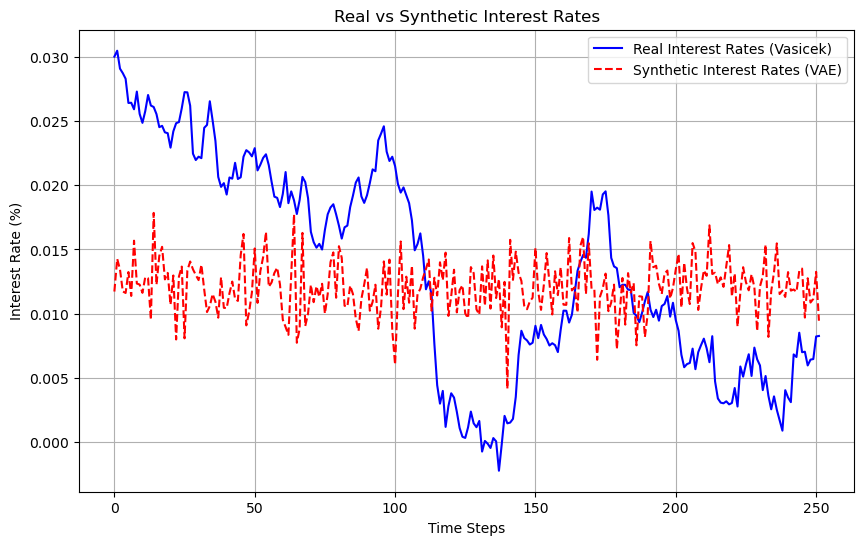

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define VAE Model (Encoder and Decoder)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc21 = nn.Linear(64, 10)  # Mean of the latent space
        self.fc22 = nn.Linear(64, 10)  # Log-variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(10, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)  # Return mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE: Reconstruction Loss + KL Divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    # KL divergence between learned distribution and unit Gaussian prior
    # D_KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where mu is the mean and sigma^2 is the variance
    # for Gaussian prior N(0, I)
    # From the VAE paper: Kingma and Welling (2013)
    # https://arxiv.org/abs/1312.6114
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# Initialize VAE model
vae = VAE()

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop for VAE
def train_vae(real_data, num_epochs=1000, batch_size=64):
    for epoch in range(num_epochs):
        for i in range(0, len(real_data), batch_size):
            batch = real_data[i:i+batch_size]
            batch = torch.tensor(batch, dtype=torch.float32).view(-1, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = vae(batch)

            # Compute loss
            loss = vae_loss(recon_batch, batch, mu, logvar)

            # Backpropagation
            loss.backward()

            # Optimizer step
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Loss: {loss.item():.4f}")

# Generate Synthetic Interest Rate Data using VAE
def generate_synthetic_data(num_samples=252):
    # Sample from the latent space (random normal distribution)
    z = torch.randn(num_samples, 10)
    with torch.no_grad():
        synthetic_data = vae.decode(z).numpy()
    return synthetic_data.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Train VAE on the real interest rate data
train_vae(real_rates)

# Generate synthetic data using the trained VAE
synthetic_rates = generate_synthetic_data()

# Plot Real vs Synthetic Interest Rates
plt.figure(figsize=(10, 6))
plt.plot(real_rates, label="Real Interest Rates (Vasicek)", color='blue')
plt.plot(synthetic_rates, label="Synthetic Interest Rates (VAE)", color='red', linestyle='dashed')
plt.title('Real vs Synthetic Interest Rates')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


Epoch [0/1000] | Loss: 2.6692
Epoch [100/1000] | Loss: 0.0012
Epoch [200/1000] | Loss: 0.0008
Epoch [300/1000] | Loss: 0.0007
Epoch [400/1000] | Loss: 0.0007
Epoch [500/1000] | Loss: 0.0007
Epoch [600/1000] | Loss: 0.0007
Epoch [700/1000] | Loss: 0.0007
Epoch [800/1000] | Loss: 0.0007
Epoch [900/1000] | Loss: 0.0007


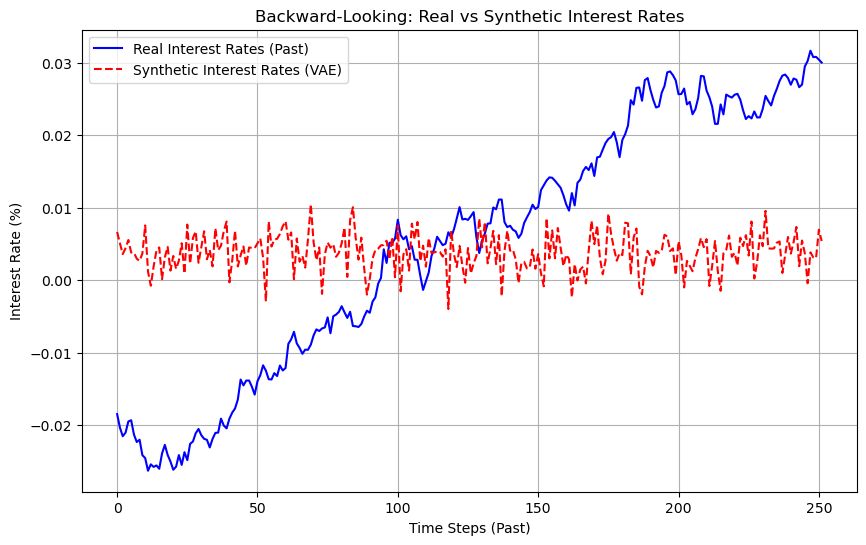

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define VAE Model (Encoder and Decoder)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc21 = nn.Linear(64, 10)  # Mean of the latent space
        self.fc22 = nn.Linear(64, 10)  # Log-variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(10, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)  # Return mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE: Reconstruction Loss + KL Divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    # KL divergence between learned distribution and unit Gaussian prior
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# Initialize VAE model
vae = VAE()

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop for VAE
def train_vae(real_data, num_epochs=1000, batch_size=64):
    for epoch in range(num_epochs):
        for i in range(0, len(real_data), batch_size):
            batch = real_data[i:i+batch_size]
            batch = torch.tensor(batch, dtype=torch.float32).view(-1, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = vae(batch)

            # Compute loss
            loss = vae_loss(recon_batch, batch, mu, logvar)

            # Backpropagation
            loss.backward()

            # Optimizer step
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Loss: {loss.item():.4f}")

# Generate Synthetic Interest Rate Data using VAE
def generate_synthetic_data(num_samples=252):
    # Sample from the latent space (random normal distribution)
    z = torch.randn(num_samples, 10)
    with torch.no_grad():
        synthetic_data = vae.decode(z).numpy()
    return synthetic_data.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Train VAE on the real interest rate data
train_vae(real_rates)

# Generate synthetic data using the trained VAE
synthetic_rates = generate_synthetic_data()

# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# Plot Real vs Synthetic Interest Rates (Backward-Looking)
plt.figure(figsize=(10, 6))
plt.plot(real_rates_backward, label="Real Interest Rates (Past)", color='blue')
plt.plot(synthetic_rates_backward, label="Synthetic Interest Rates (VAE)", color='red', linestyle='dashed')
plt.title('Backward-Looking: Real vs Synthetic Interest Rates')
plt.xlabel('Time Steps (Past)')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


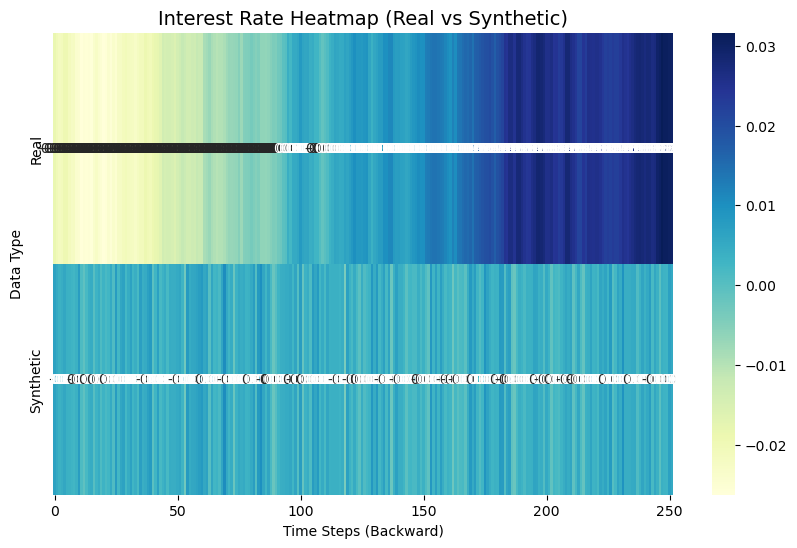

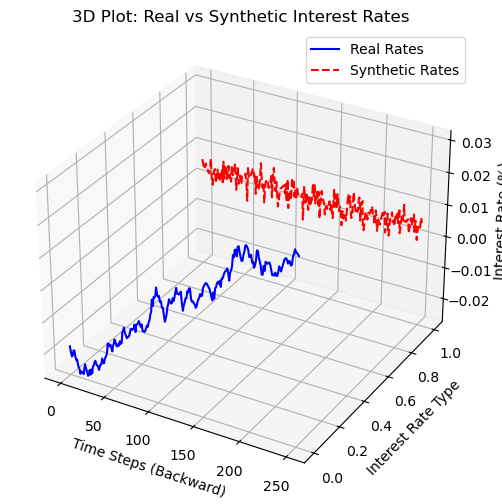

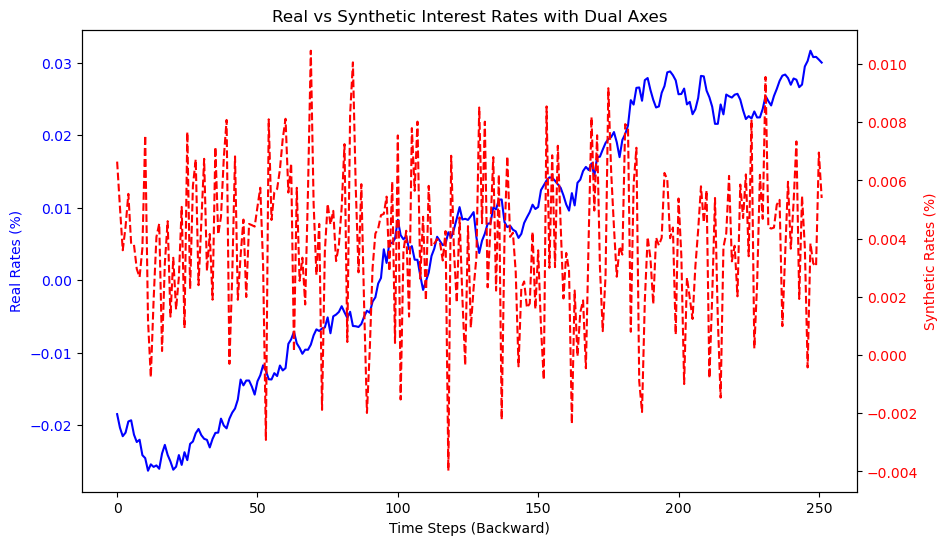

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Assuming real_rates and synthetic_rates are already generated
# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# 1. **Heatmap**: Show interest rate data as a heatmap
def plot_heatmap():
    # Create a 2D array for the heatmap (e.g., interest rates over time for different samples)
    data = np.array([real_rates_backward, synthetic_rates_backward])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, xticklabels=50, yticklabels=["Real", "Synthetic"])
    plt.title('Interest Rate Heatmap (Real vs Synthetic)', fontsize=14)
    plt.xlabel('Time Steps (Backward)')
    plt.ylabel('Data Type')
    plt.show()

# 2. **3D Plot**: Visualize the evolution of interest rates over time in 3D
def plot_3d():
    # Creating a 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Time as the x-axis
    time = np.arange(len(real_rates_backward))
    
    # Plot real and synthetic interest rates as 3D lines
    ax.plot(time, real_rates_backward, zs=0, zdir='y', label='Real Rates', color='b')
    ax.plot(time, synthetic_rates_backward, zs=1, zdir='y', label='Synthetic Rates', color='r', linestyle='dashed')

    ax.set_xlabel('Time Steps (Backward)')
    ax.set_ylabel('Interest Rate Type')
    ax.set_zlabel('Interest Rate (%)')
    ax.set_title('3D Plot: Real vs Synthetic Interest Rates')
    ax.legend()
    plt.show()

# 3. **Dual-Axis Plot**: Plot real and synthetic rates on separate y-axes
def plot_dual_axis():
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot real interest rates on the primary y-axis (left)
    ax1.plot(real_rates_backward, color='blue', label='Real Interest Rates')
    ax1.set_xlabel('Time Steps (Backward)')
    ax1.set_ylabel('Real Rates (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for synthetic rates
    ax2 = ax1.twinx()
    ax2.plot(synthetic_rates_backward, color='red', linestyle='dashed', label='Synthetic Interest Rates')
    ax2.set_ylabel('Synthetic Rates (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and show plot
    plt.title('Real vs Synthetic Interest Rates with Dual Axes')
    plt.show()

# Call the functions to display each plot
plot_heatmap()
plot_3d()
plot_dual_axis()


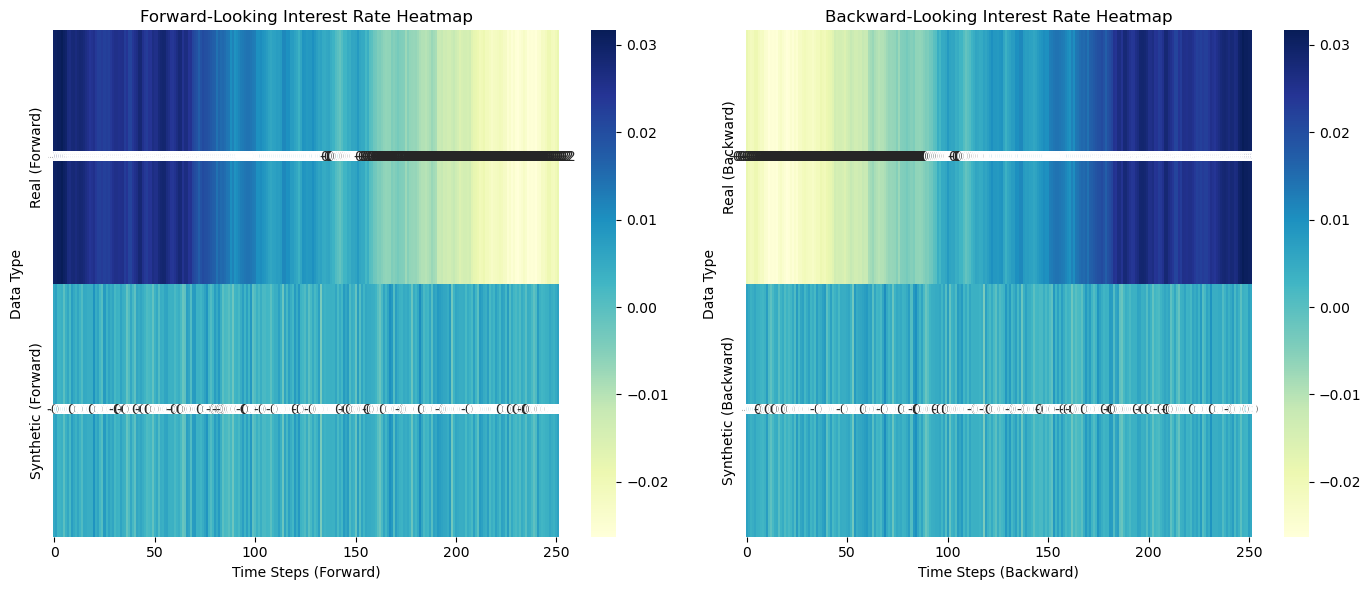

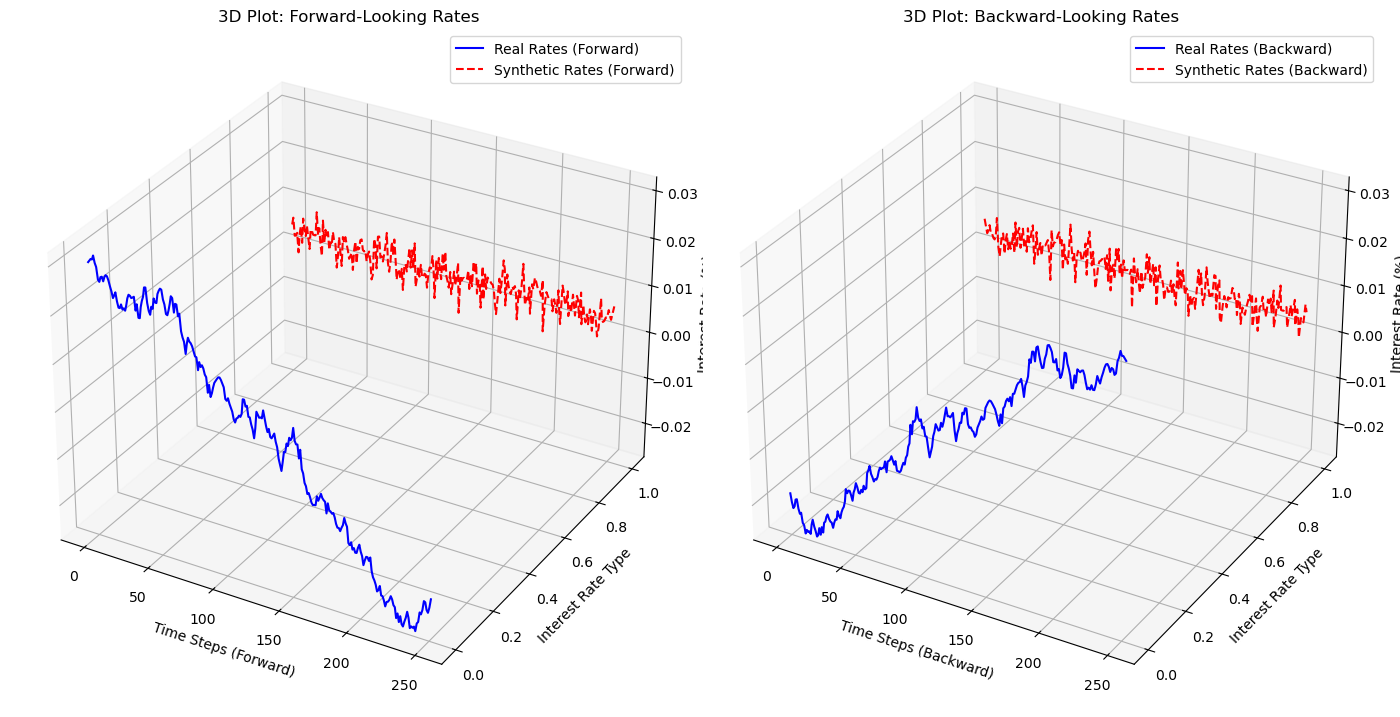

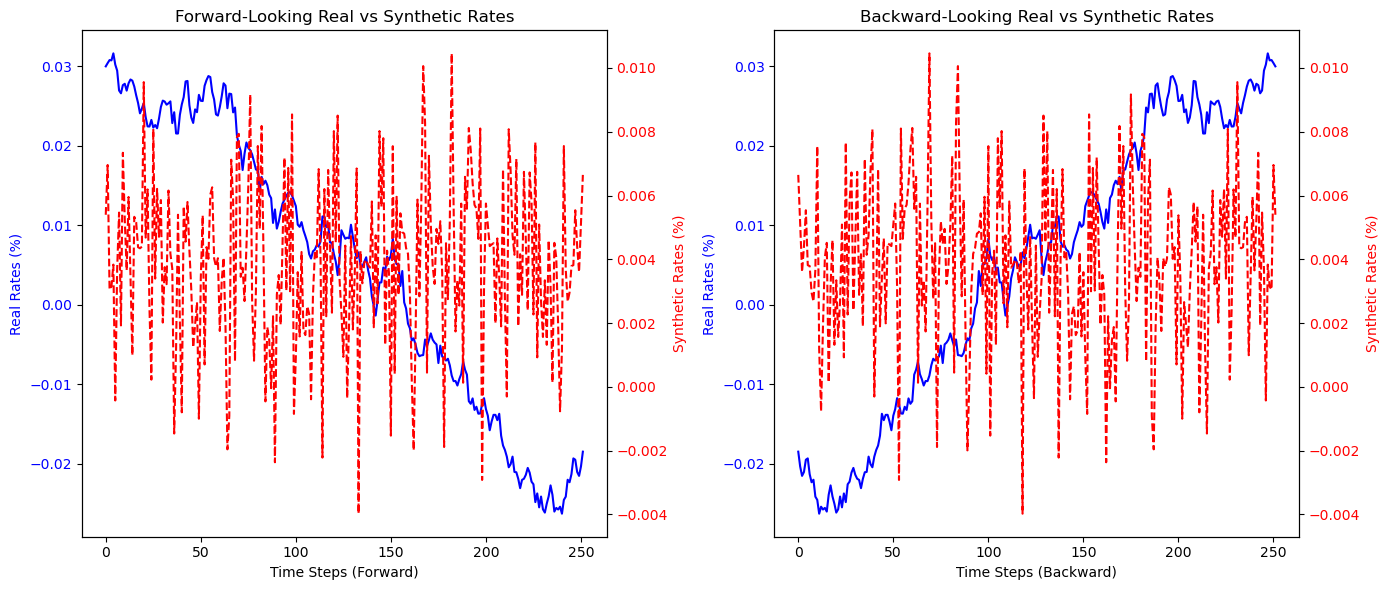

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Assuming real_rates and synthetic_rates are already generated

# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# Forward-Looking Data (Same as original data)
real_rates_forward = real_rates
synthetic_rates_forward = synthetic_rates

# 1. **Heatmap**: Show interest rate data as a heatmap
def plot_heatmap():
    # Create a 2D array for the heatmap (interest rates for both forward and backward)
    data_forward = np.array([real_rates_forward, synthetic_rates_forward])
    data_backward = np.array([real_rates_backward, synthetic_rates_backward])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Forward Heatmap
    sns.heatmap(data_forward, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, xticklabels=50, yticklabels=["Real (Forward)", "Synthetic (Forward)"], ax=axes[0])
    axes[0].set_title('Forward-Looking Interest Rate Heatmap')
    axes[0].set_xlabel('Time Steps (Forward)')
    axes[0].set_ylabel('Data Type')

    # Backward Heatmap
    sns.heatmap(data_backward, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, xticklabels=50, yticklabels=["Real (Backward)", "Synthetic (Backward)"], ax=axes[1])
    axes[1].set_title('Backward-Looking Interest Rate Heatmap')
    axes[1].set_xlabel('Time Steps (Backward)')
    axes[1].set_ylabel('Data Type')
    
    plt.tight_layout()
    plt.show()

# 2. **3D Plot**: Visualize the evolution of interest rates over time in 3D
def plot_3d():
    # Creating a 3D plot for forward and backward looking data
    fig = plt.figure(figsize=(14, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Time as the x-axis
    time_forward = np.arange(len(real_rates_forward))
    time_backward = np.arange(len(real_rates_backward))

    # Forward 3D Plot
    ax1.plot(time_forward, real_rates_forward, zs=0, zdir='y', label='Real Rates (Forward)', color='b')
    ax1.plot(time_forward, synthetic_rates_forward, zs=1, zdir='y', label='Synthetic Rates (Forward)', color='r', linestyle='dashed')
    ax1.set_xlabel('Time Steps (Forward)')
    ax1.set_ylabel('Interest Rate Type')
    ax1.set_zlabel('Interest Rate (%)')
    ax1.set_title('3D Plot: Forward-Looking Rates')
    ax1.legend()

    # Backward 3D Plot
    ax2.plot(time_backward, real_rates_backward, zs=0, zdir='y', label='Real Rates (Backward)', color='b')
    ax2.plot(time_backward, synthetic_rates_backward, zs=1, zdir='y', label='Synthetic Rates (Backward)', color='r', linestyle='dashed')
    ax2.set_xlabel('Time Steps (Backward)')
    ax2.set_ylabel('Interest Rate Type')
    ax2.set_zlabel('Interest Rate (%)')
    ax2.set_title('3D Plot: Backward-Looking Rates')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 3. **Dual-Axis Plot**: Plot real and synthetic rates on separate y-axes for forward and backward
def plot_dual_axis():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Forward Dual-Axis Plot
    ax1 = axes[0]
    ax1.plot(real_rates_forward, color='blue', label='Real Interest Rates (Forward)')
    ax1.set_xlabel('Time Steps (Forward)')
    ax1.set_ylabel('Real Rates (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(synthetic_rates_forward, color='red', linestyle='dashed', label='Synthetic Interest Rates (Forward)')
    ax2.set_ylabel('Synthetic Rates (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title('Forward-Looking Real vs Synthetic Rates')
    
    # Backward Dual-Axis Plot
    ax1 = axes[1]
    ax1.plot(real_rates_backward, color='blue', label='Real Interest Rates (Backward)')
    ax1.set_xlabel('Time Steps (Backward)')
    ax1.set_ylabel('Real Rates (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(synthetic_rates_backward, color='red', linestyle='dashed', label='Synthetic Interest Rates (Backward)')
    ax2.set_ylabel('Synthetic Rates (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title('Backward-Looking Real vs Synthetic Rates')
    
    plt.tight_layout()
    plt.show()

# Call the functions to display each plot
plot_heatmap()
plot_3d()
plot_dual_axis()


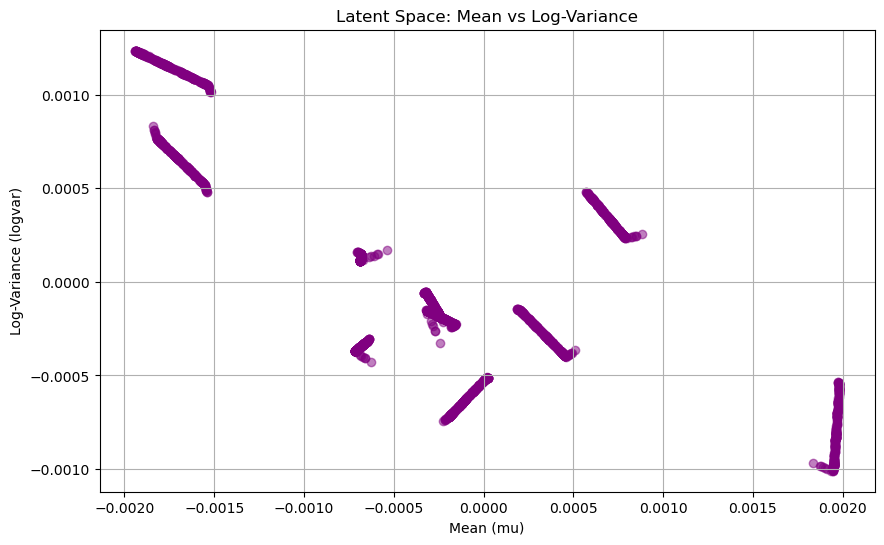

In [15]:
def plot_latent_space(real_data):
    # Convert real_data into torch tensor and reshape for encoding
    real_data_tensor = torch.tensor(real_data, dtype=torch.float32).view(-1, 1)
    
    # Get latent variables (mean and log-variance)
    mu, logvar = [], []
    with torch.no_grad():
        for i in range(0, len(real_data_tensor), 64):  # Batch processing
            batch = real_data_tensor[i:i+64]
            mu_batch, logvar_batch = vae.encode(batch)
            mu.append(mu_batch.numpy())
            logvar.append(logvar_batch.numpy())
    
    mu = np.concatenate(mu, axis=0)
    logvar = np.concatenate(logvar, axis=0)

    # Plot the latent space
    plt.figure(figsize=(10, 6))
    plt.scatter(mu, logvar, color='purple', alpha=0.5)
    plt.title('Latent Space: Mean vs Log-Variance')
    plt.xlabel('Mean (mu)')
    plt.ylabel('Log-Variance (logvar)')
    plt.grid(True)
    plt.show()
    
# Plot Latent Space
plot_latent_space(real_rates)


Epoch [0/1000] | Loss: 0.0025
Epoch [100/1000] | Loss: 0.0111
Epoch [200/1000] | Loss: 0.0032
Epoch [300/1000] | Loss: 0.0029
Epoch [400/1000] | Loss: 0.0018
Epoch [500/1000] | Loss: 0.0020
Epoch [600/1000] | Loss: 0.0021
Epoch [700/1000] | Loss: 0.0015
Epoch [800/1000] | Loss: 0.0016
Epoch [900/1000] | Loss: 0.0017


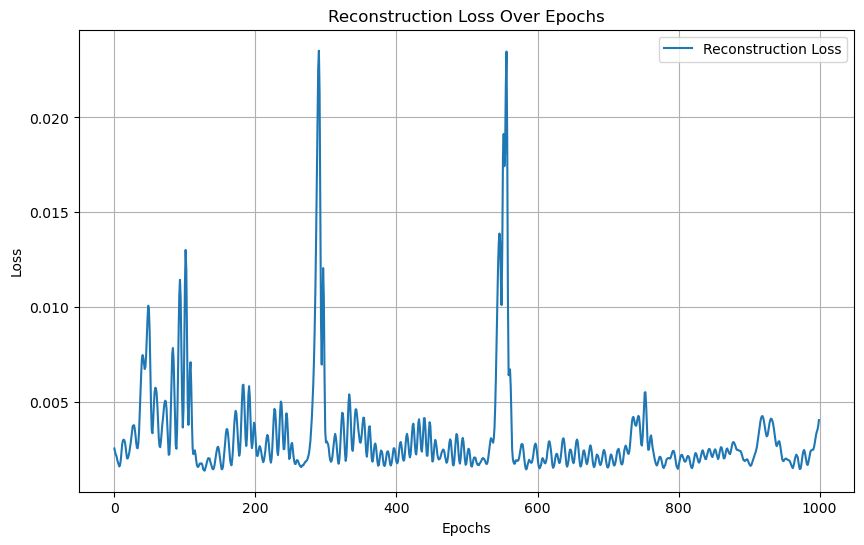

In [16]:
def plot_reconstruction_loss():
    losses = []
    
    # Capture loss during training
    def train_vae_with_loss_logging(real_data, num_epochs=1000, batch_size=64):
        for epoch in range(num_epochs):
            epoch_loss = 0
            for i in range(0, len(real_data), batch_size):
                batch = real_data[i:i+batch_size]
                batch = torch.tensor(batch, dtype=torch.float32).view(-1, 1)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                recon_batch, mu, logvar = vae(batch)

                # Compute loss
                loss = vae_loss(recon_batch, batch, mu, logvar)

                # Backpropagation
                loss.backward()

                # Optimizer step
                optimizer.step()

                epoch_loss += loss.item()

            # Log the loss for the epoch
            losses.append(epoch_loss)

            if epoch % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] | Loss: {epoch_loss:.4f}")

    # Train and log loss
    train_vae_with_loss_logging(real_rates)

    # Plot reconstruction loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Reconstruction Loss')
    plt.title('Reconstruction Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Reconstruction Loss
plot_reconstruction_loss()


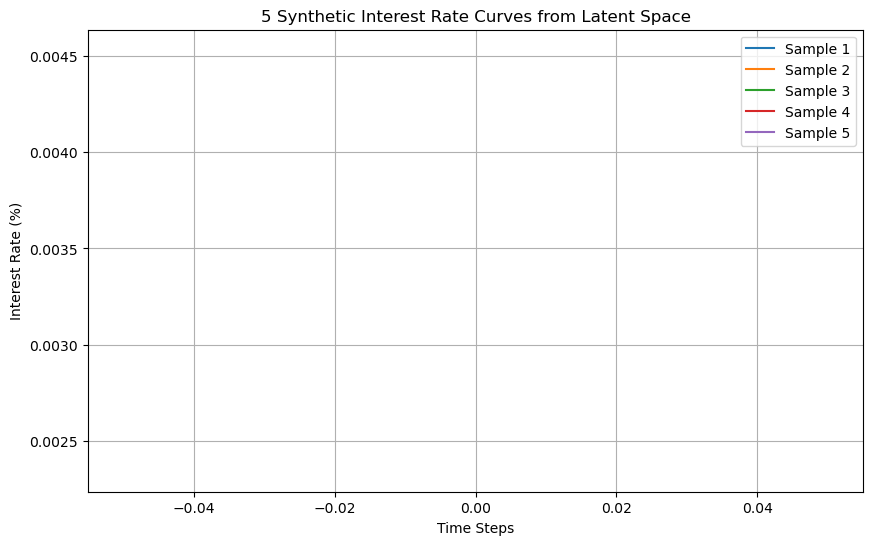

In [17]:
def plot_latent_factor_samples(num_samples=5):
    z_samples = torch.randn(num_samples, 10)  # Latent space samples

    with torch.no_grad():
        synthetic_samples = vae.decode(z_samples).numpy()

    # Plot synthetic interest rate data samples
    plt.figure(figsize=(10, 6))
    for i, sample in enumerate(synthetic_samples):
        plt.plot(sample, label=f'Sample {i+1}')

    plt.title(f'{num_samples} Synthetic Interest Rate Curves from Latent Space')
    plt.xlabel('Time Steps')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot synthetic interest rate curves
plot_latent_factor_samples()


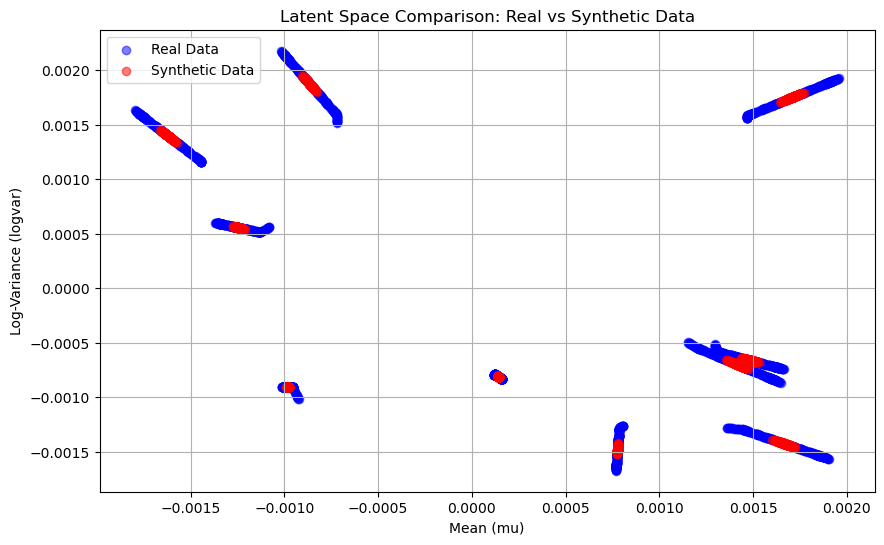

In [18]:
def compare_real_and_synthetic_in_latent_space(real_data, synthetic_data):
    # Encode both real and synthetic data
    real_data_tensor = torch.tensor(real_data, dtype=torch.float32).view(-1, 1)
    synthetic_data_tensor = torch.tensor(synthetic_data, dtype=torch.float32).view(-1, 1)
    
    # Get latent variables
    real_mu, real_logvar = [], []
    synthetic_mu, synthetic_logvar = [], []
    with torch.no_grad():
        for i in range(0, len(real_data_tensor), 64):  # Batch processing
            batch_real = real_data_tensor[i:i+64]
            batch_synthetic = synthetic_data_tensor[i:i+64]
            
            real_mu_batch, real_logvar_batch = vae.encode(batch_real)
            synthetic_mu_batch, synthetic_logvar_batch = vae.encode(batch_synthetic)
            
            real_mu.append(real_mu_batch.numpy())
            real_logvar.append(real_logvar_batch.numpy())
            synthetic_mu.append(synthetic_mu_batch.numpy())
            synthetic_logvar.append(synthetic_logvar_batch.numpy())

    real_mu = np.concatenate(real_mu, axis=0)
    real_logvar = np.concatenate(real_logvar, axis=0)
    synthetic_mu = np.concatenate(synthetic_mu, axis=0)
    synthetic_logvar = np.concatenate(synthetic_logvar, axis=0)

    # Plot comparison in the latent space
    plt.figure(figsize=(10, 6))
    plt.scatter(real_mu, real_logvar, color='blue', alpha=0.5, label='Real Data')
    plt.scatter(synthetic_mu, synthetic_logvar, color='red', alpha=0.5, label='Synthetic Data')
    plt.title('Latent Space Comparison: Real vs Synthetic Data')
    plt.xlabel('Mean (mu)')
    plt.ylabel('Log-Variance (logvar)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare real and synthetic data in latent space
compare_real_and_synthetic_in_latent_space(real_rates, synthetic_rates)


ValueError: operands could not be broadcast together with shapes (233,) (232,) 

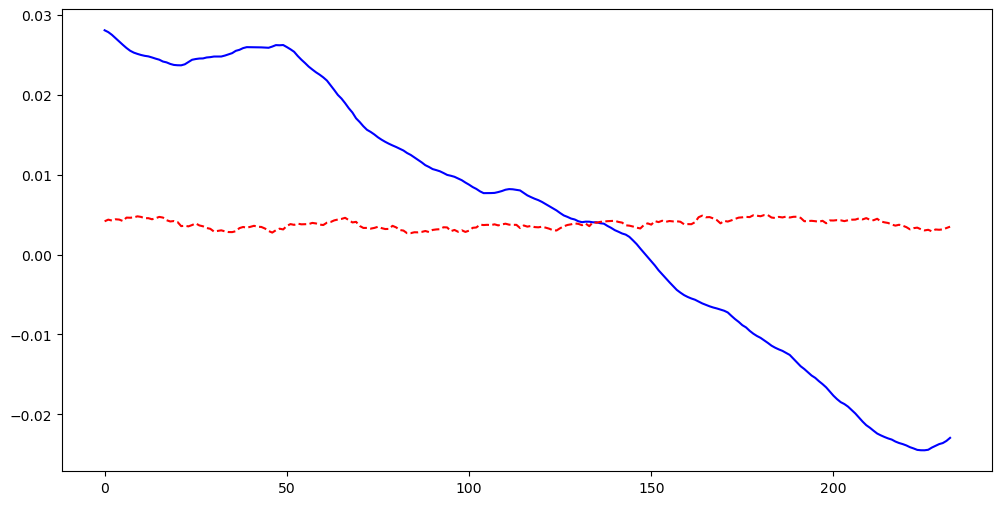

In [19]:
def plot_rolling_stats():
    window_size = 20

    real_rolling_mean = np.convolve(real_rates, np.ones(window_size)/window_size, mode='valid')
    synthetic_rolling_mean = np.convolve(synthetic_rates, np.ones(window_size)/window_size, mode='valid')

    real_rolling_std = np.std([real_rates[i:i+window_size] for i in range(len(real_rates)-window_size)], axis=1)
    synthetic_rolling_std = np.std([synthetic_rates[i:i+window_size] for i in range(len(synthetic_rates)-window_size)], axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(real_rolling_mean, label="Real Rolling Mean", color='blue')
    plt.plot(synthetic_rolling_mean, label="Synthetic Rolling Mean", color='red', linestyle='dashed')
    plt.fill_between(range(len(real_rolling_mean)), real_rolling_mean - real_rolling_std, real_rolling_mean + real_rolling_std, color='blue', alpha=0.2)
    plt.fill_between(range(len(synthetic_rolling_mean)), synthetic_rolling_mean - synthetic_rolling_std, synthetic_rolling_mean + synthetic_rolling_std, color='red', alpha=0.2)

    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Time Steps')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_stats()


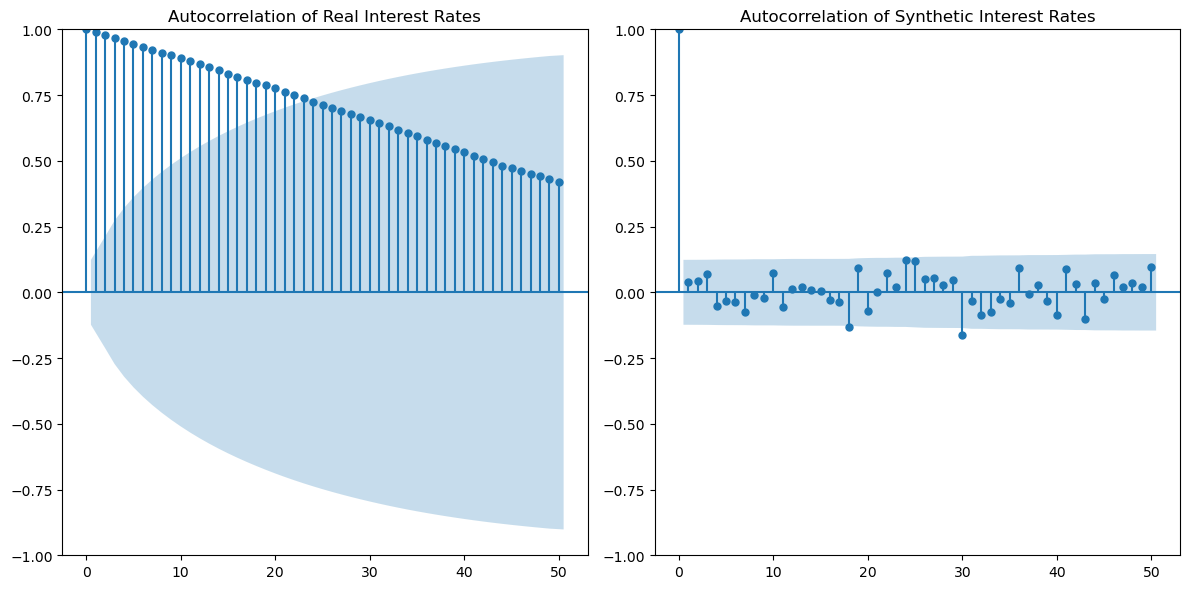

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acf_comparison():
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_acf(real_rates, lags=50, ax=plt.gca(), title="Autocorrelation of Real Interest Rates")

    plt.subplot(1, 2, 2)
    plot_acf(synthetic_rates, lags=50, ax=plt.gca(), title="Autocorrelation of Synthetic Interest Rates")
    
    plt.tight_layout()
    plt.show()

plot_acf_comparison()


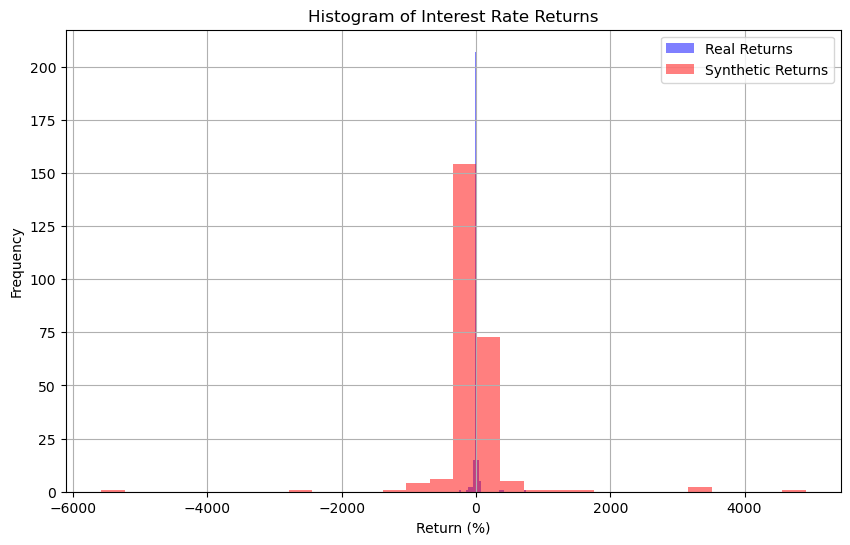

In [21]:
def plot_returns_histogram():
    real_returns = np.diff(real_rates) / real_rates[:-1] * 100  # Percentage changes in real rates
    synthetic_returns = np.diff(synthetic_rates) / synthetic_rates[:-1] * 100  # Percentage changes in synthetic rates

    plt.figure(figsize=(10, 6))
    plt.hist(real_returns, bins=30, alpha=0.5, label='Real Returns', color='blue')
    plt.hist(synthetic_returns, bins=30, alpha=0.5, label='Synthetic Returns', color='red')
    
    plt.title('Histogram of Interest Rate Returns')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_returns_histogram()


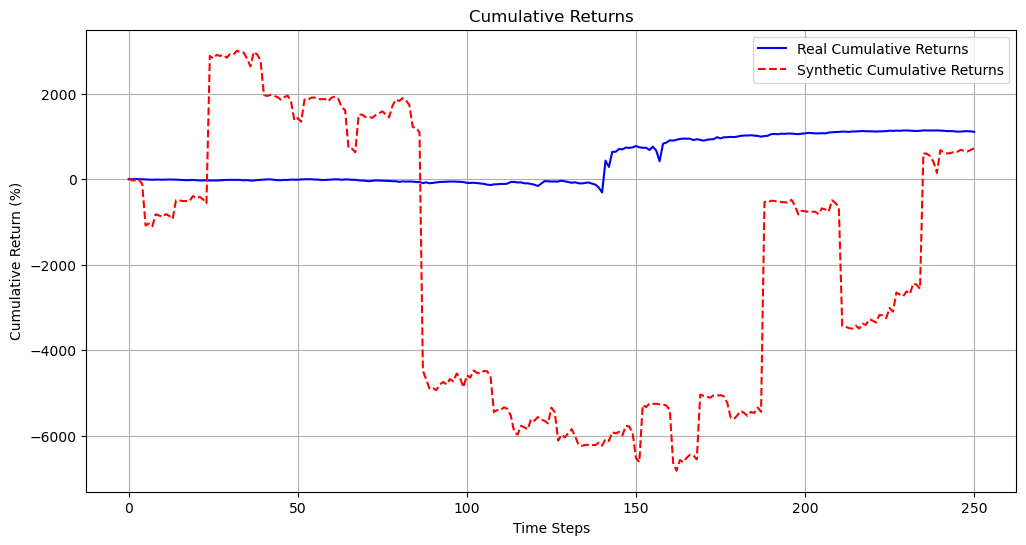

In [22]:
def plot_cumulative_returns():
    real_returns = np.diff(real_rates) / real_rates[:-1] * 100  # Percentage changes in real rates
    synthetic_returns = np.diff(synthetic_rates) / synthetic_rates[:-1] * 100  # Percentage changes in synthetic rates

    real_cumulative = np.cumsum(real_returns)
    synthetic_cumulative = np.cumsum(synthetic_returns)

    plt.figure(figsize=(12, 6))
    plt.plot(real_cumulative, label="Real Cumulative Returns", color='blue')
    plt.plot(synthetic_cumulative, label="Synthetic Cumulative Returns", color='red', linestyle='dashed')

    plt.title('Cumulative Returns')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_returns()


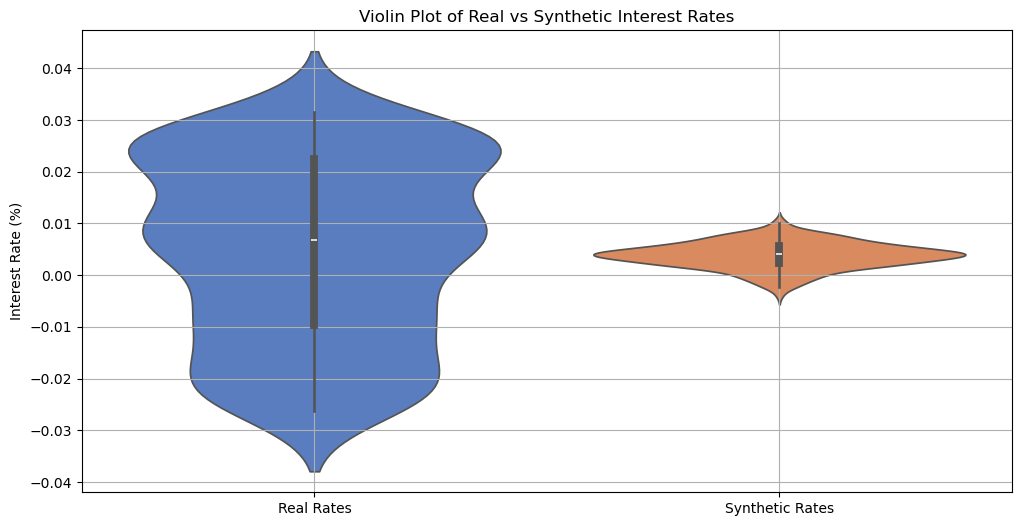

In [23]:
import seaborn as sns

def plot_violin_comparison():
    data = {
        'Real Rates': real_rates,
        'Synthetic Rates': synthetic_rates
    }
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=data, palette="muted")

    plt.title('Violin Plot of Real vs Synthetic Interest Rates')
    plt.ylabel('Interest Rate (%)')
    plt.grid(True)
    plt.show()

plot_violin_comparison()


/tmp/ipykernel_9533/4277641397.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Real Rates", "Synthetic Rates"], patch_artist=True)


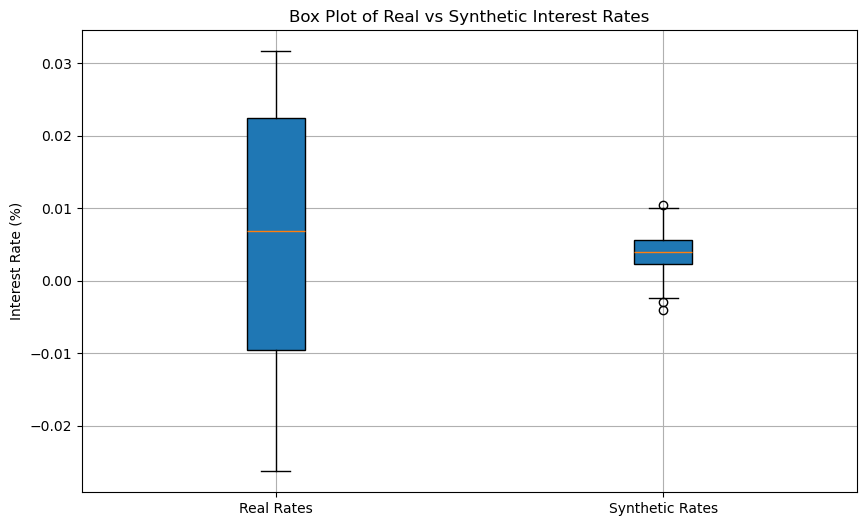

In [24]:
def plot_boxplot_comparison():
    data = [real_rates, synthetic_rates]
    
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=["Real Rates", "Synthetic Rates"], patch_artist=True)

    plt.title('Box Plot of Real vs Synthetic Interest Rates')
    plt.ylabel('Interest Rate (%)')
    plt.grid(True)
    plt.show()

plot_boxplot_comparison()


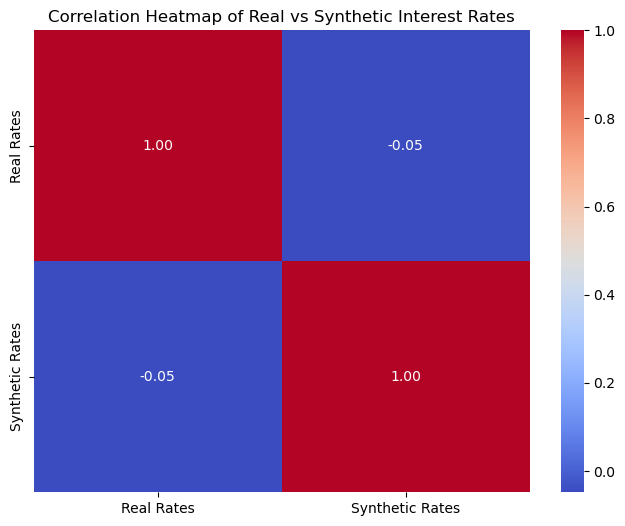

In [25]:
import seaborn as sns
import pandas as pd

def plot_correlation_heatmap():
    # Assuming you have more time-series or features, like macroeconomic data
    data = {
        'Real Rates': real_rates,
        'Synthetic Rates': synthetic_rates
    }
    
    df = pd.DataFrame(data)
    corr_matrix = df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

    plt.title('Correlation Heatmap of Real vs Synthetic Interest Rates')
    plt.show()

plot_correlation_heatmap()


Graph saved as citation_relationship_20250127_212641.png


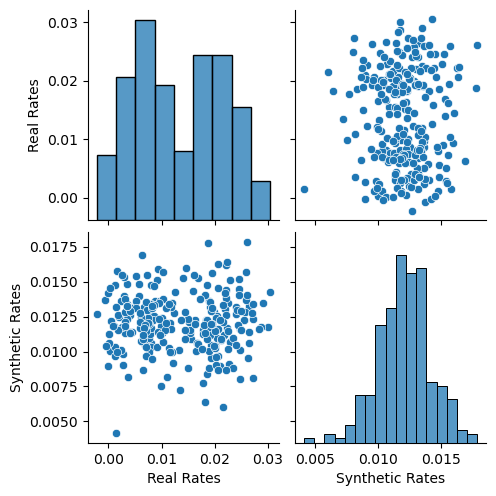

In [66]:
import seaborn as sns

def plot_pairplot():
    # Assuming you have additional variables such as 'real_rates', 'synthetic_rates' and more
    data = {
        'Real Rates': real_rates,
        'Synthetic Rates': synthetic_rates
    }

    df = pd.DataFrame(data)

    sns.pairplot(df)
    import time

    # Generate a timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # Save the plot with a timestamp in the filename
    filename = f"citation_relationship_{timestamp}.png"
    plt.savefig(filename)
    
    # Optionally, you can print the filename for reference
    print(f"Graph saved as {filename}")
    plt.show()

plot_pairplot()


Epoch [0/5000] | D Loss: 1.4046 | G Loss: 0.8144
Epoch [1000/5000] | D Loss: 1.3837 | G Loss: 0.6944
Epoch [2000/5000] | D Loss: 1.3865 | G Loss: 0.6931
Epoch [3000/5000] | D Loss: 1.3866 | G Loss: 0.6930
Epoch [4000/5000] | D Loss: 1.3865 | G Loss: 0.6930


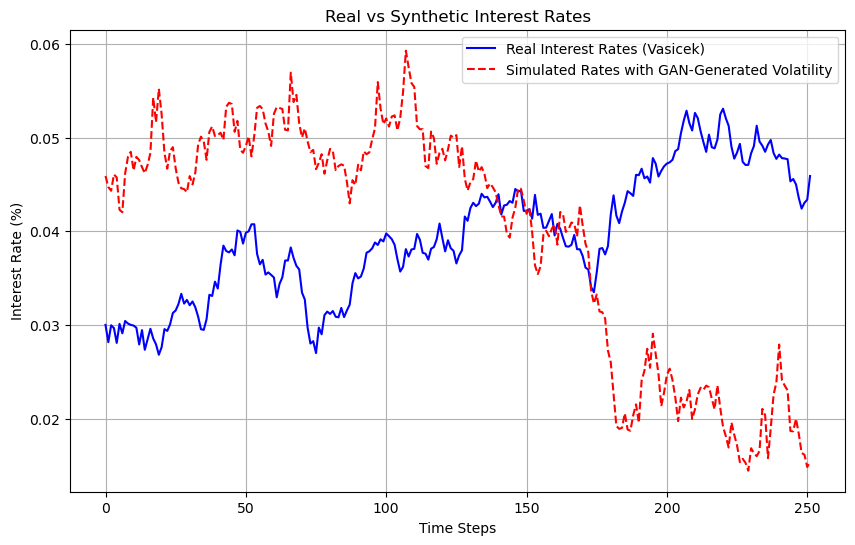

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define the GAN Model (Generator and Discriminator) for generating volatility (sigma)
class VolatilityGenerator(nn.Module):
    def __init__(self):
        super(VolatilityGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)  # Generate single volatility value
        )

    def forward(self, z):
        return self.fc(z)

class VolatilityDiscriminator(nn.Module):
    def __init__(self):
        super(VolatilityDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize Generator and Discriminator for volatility
volatility_generator = VolatilityGenerator()
volatility_discriminator = VolatilityDiscriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(volatility_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(volatility_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train GAN for Volatility
def train_volatility_gan(real_data, num_epochs=5000, batch_size=64):
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    for epoch in range(num_epochs):
        # Train Discriminator
        volatility_discriminator.zero_grad()

        # Generate random indices using PyTorch
        indices = torch.randint(0, len(real_data), (batch_size,))
        
        # Use index_select for slicing
        real_inputs = torch.index_select(torch.tensor(real_data, dtype=torch.float32), 0, indices).view(-1, 1)
        real_outputs = volatility_discriminator(real_inputs)
        real_loss = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, 100)  # Random noise for generator
        fake_inputs = volatility_generator(z)
        fake_outputs = volatility_discriminator(fake_inputs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        volatility_generator.zero_grad()
        fake_outputs = volatility_discriminator(fake_inputs)
        g_loss = criterion(fake_outputs, real_labels)  # Fool the Discriminator
        g_loss.backward()
        optimizer_g.step()

        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")




# Generate Synthetic Volatility using the trained Generator
def generate_synthetic_volatility(num_samples=252):
    z = torch.randn(num_samples, 100)
    synthetic_volatility = volatility_generator(z).detach().numpy()
    return synthetic_volatility.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Calculate historical volatility from real rates (based on daily returns)
def calculate_volatility(rates, window=252):
    returns = np.diff(rates) / rates[:-1]  # Daily returns
    volatility = np.std(returns[-window:])  # Standard deviation of returns over the last window
    return volatility

# Create volatility dataset from real rates (calculated volatility)
real_volatility = [calculate_volatility(real_rates[:i+1]) for i in range(1, len(real_rates))]

# Train GAN on real volatility data
train_volatility_gan(real_volatility)

# Generate synthetic volatility using the trained GAN
synthetic_volatility = generate_synthetic_volatility()

# Simulate interest rates with GAN-generated volatility
def simulate_vasicek_with_gan_volatility(r0, kappa, theta, num_steps, volatility_generator):
    # Use GAN to generate volatility for each step
    z = torch.randn(1, 100)  # Noise for GAN
    generated_volatility = volatility_generator(z).item()  # Generate a single volatility value

    dt = 1 / 252  # Assume daily frequency
    rates = np.zeros(num_steps)
    rates[0] = r0

    for t in range(1, num_steps):
        # Simulate the next rate using the Vasicek model with generated volatility
        dr = kappa * (theta - rates[t-1]) * dt + generated_volatility * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr

    return rates

# Simulate future interest rates using GAN-generated volatility
r0 = real_rates[-1]  # Use last observed rate as the starting point
kappa = 0.1  # Example mean reversion speed
theta = 0.04  # Example long-term mean

# Simulate interest rates with GAN-generated volatility
simulated_rates = simulate_vasicek_with_gan_volatility(r0, kappa, theta, 252, volatility_generator)

# Plot Real vs Synthetic Interest Rates
plt.figure(figsize=(10, 6))
plt.plot(real_rates, label="Real Interest Rates (Vasicek)", color='blue')
plt.plot(simulated_rates, label="Simulated Rates with GAN-Generated Volatility", color='red', linestyle='dashed')
plt.title('Real vs Synthetic Interest Rates')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


Epoch [0/1000] | Loss: 0.7897
Epoch [100/1000] | Loss: 0.0003
Epoch [200/1000] | Loss: 0.0002
Epoch [300/1000] | Loss: 0.0002
Epoch [400/1000] | Loss: 0.0003
Epoch [500/1000] | Loss: 0.0001
Epoch [600/1000] | Loss: 0.0001
Epoch [700/1000] | Loss: 0.0001
Epoch [800/1000] | Loss: 0.0001
Epoch [900/1000] | Loss: 0.0001
Graph saved as citation_relationship_20250127_212703.png


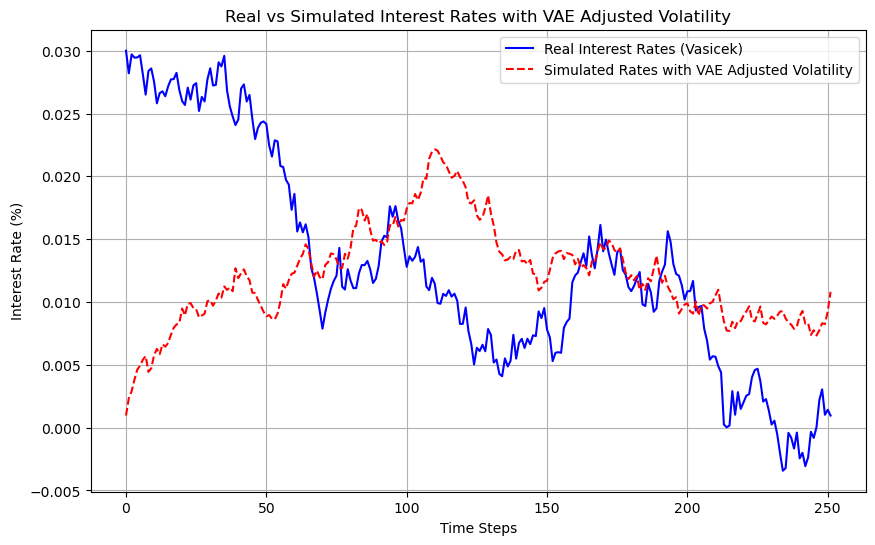

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define VAE Model (Encoder and Decoder)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc21 = nn.Linear(64, 10)  # Mean of the latent space
        self.fc22 = nn.Linear(64, 10)  # Log-variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(10, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)  # Return mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE: Reconstruction Loss + KL Divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    # KL divergence between learned distribution and unit Gaussian prior
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# Initialize VAE model
vae = VAE()

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop for VAE
def train_vae(real_data, num_epochs=1000, batch_size=64):
    for epoch in range(num_epochs):
        for i in range(0, len(real_data), batch_size):
            batch = real_data[i:i+batch_size]
            batch = torch.tensor(batch, dtype=torch.float32).view(-1, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = vae(batch)

            # Compute loss
            loss = vae_loss(recon_batch, batch, mu, logvar)

            # Backpropagation
            loss.backward()

            # Optimizer step
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Loss: {loss.item():.4f}")

# Generate Synthetic Interest Rate Data using VAE
def generate_synthetic_data(num_samples=252):
    # Sample from the latent space (random normal distribution)
    z = torch.randn(num_samples, 10)
    with torch.no_grad():
        synthetic_data = vae.decode(z).numpy()
    return synthetic_data.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Train VAE on the real interest rate data
train_vae(real_rates)

# Generate synthetic data using the trained VAE
synthetic_rates = generate_synthetic_data()

# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# Use the VAE output to adjust Vasicek parameters (volatility)
def simulate_vasicek_with_vae_output(r0, kappa, theta, num_steps, volatility_latent_space):
    # Use VAE's latent space output to adjust volatility
    adjusted_volatility = np.mean(volatility_latent_space)  # Adjust based on VAE's output
    
    dt = 1 / 252  # Assume daily frequency
    rates = np.zeros(num_steps)
    rates[0] = r0

    for t in range(1, num_steps):
        # Simulate the next rate using the Vasicek model with adjusted volatility
        dr = kappa * (theta - rates[t-1]) * dt + adjusted_volatility * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr

    return rates

# Simulate future interest rates using VAE output for volatility adjustment
r0 = real_rates[-1]  # Use last observed rate as the starting point
kappa = 0.1  # Example mean reversion speed
theta = 0.04  # Example long-term mean

# Simulate interest rates with adjusted volatility from the VAE output
simulated_rates = simulate_vasicek_with_vae_output(r0, kappa, theta, 252, synthetic_rates)

# Plot Real vs Synthetic Interest Rates (Backward-Looking)
plt.figure(figsize=(10, 6))
plt.plot(real_rates, label="Real Interest Rates (Vasicek)", color='blue')
plt.plot(simulated_rates, label="Simulated Rates with VAE Adjusted Volatility", color='red', linestyle='dashed')
plt.title('Real vs Simulated Interest Rates with VAE Adjusted Volatility')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


Epoch [0/1000] | Loss: 1.7467
Epoch [100/1000] | Loss: 0.0002
Epoch [200/1000] | Loss: 0.0001
Epoch [300/1000] | Loss: 0.0001
Epoch [400/1000] | Loss: 0.0001
Epoch [500/1000] | Loss: 0.0001
Epoch [600/1000] | Loss: 0.0001
Epoch [700/1000] | Loss: 0.0001
Epoch [800/1000] | Loss: 0.0000
Epoch [900/1000] | Loss: 0.0019


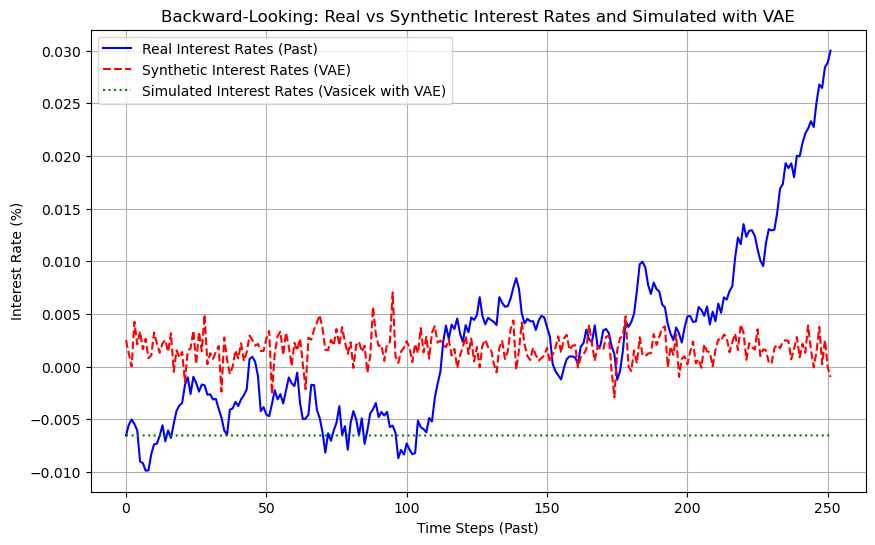

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate Interest Rate Data using the Vasicek Model
def simulate_vasicek(dt=1/252, T=1, kappa=0.1, theta=0.05, sigma=0.02, r0=0.03):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        rates[t] = rates[t-1] + dr
    return rates

# Define VAE Model (Encoder and Decoder)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc21 = nn.Linear(64, 10)  # Mean of the latent space
        self.fc22 = nn.Linear(64, 10)  # Log-variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(10, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)  # Return mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE: Reconstruction Loss + KL Divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    # KL divergence between learned distribution and unit Gaussian prior
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# Initialize VAE model
vae = VAE()

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop for VAE
def train_vae(real_data, num_epochs=1000, batch_size=64):
    for epoch in range(num_epochs):
        for i in range(0, len(real_data), batch_size):
            batch = real_data[i:i+batch_size]
            batch = torch.tensor(batch, dtype=torch.float32).view(-1, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = vae(batch)

            # Compute loss
            loss = vae_loss(recon_batch, batch, mu, logvar)

            # Backpropagation
            loss.backward()

            # Optimizer step
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Loss: {loss.item():.4f}")

# Generate Synthetic Interest Rate Data using VAE
def generate_synthetic_data(num_samples=252):
    # Sample from the latent space (random normal distribution)
    z = torch.randn(num_samples, 10)
    with torch.no_grad():
        synthetic_data = vae.decode(z).numpy()
    return synthetic_data.flatten()

# Simulate real interest rate data with Vasicek model
real_rates = simulate_vasicek()

# Train VAE on the real interest rate data
train_vae(real_rates)

# Generate synthetic data using the trained VAE
synthetic_rates = generate_synthetic_data()

# Reverse the time series for backward-looking comparison
real_rates_backward = real_rates[::-1]
synthetic_rates_backward = synthetic_rates[::-1]

# **Incorporate VAE output into Vasicek model**
# Use the mean values from VAE's latent space as parameters for Vasicek model
latent_mean, _ = vae.encode(torch.tensor(real_rates, dtype=torch.float32).view(-1, 1))

# Let's use the latent mean to adjust Vasicek's parameters dynamically
adjusted_kappa = latent_mean[:, 0].mean().item()  # Use the mean of latent space as kappa
adjusted_theta = latent_mean[:, 0].mean().item()  # Use it also to adjust theta
adjusted_sigma = latent_mean[:, 0].mean().item()  # Use it also for sigma

# Simulate future rates using adjusted Vasicek parameters
simulated_rates = simulate_vasicek(dt=1/252, T=1, kappa=adjusted_kappa, theta=adjusted_theta, sigma=adjusted_sigma, r0=real_rates[-1])

# Plot Real vs Synthetic Interest Rates (Backward-Looking)
plt.figure(figsize=(10, 6))
plt.plot(real_rates_backward, label="Real Interest Rates (Past)", color='blue')
plt.plot(synthetic_rates_backward, label="Synthetic Interest Rates (VAE)", color='red', linestyle='dashed')
plt.plot(simulated_rates, label="Simulated Interest Rates (Vasicek with VAE)", color='green', linestyle='dotted')
plt.title('Backward-Looking: Real vs Synthetic Interest Rates and Simulated with VAE')
plt.xlabel('Time Steps (Past)')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


Data downloaded successfully.
Estimated Parameters:
Kappa (mean reversion speed): 6.254991206070167
Theta (long-term mean): 2.881350151353567
Sigma (volatility): 40.91905530780289


/tmp/ipykernel_9533/1469850226.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r0 = rates[-1]  # Use the last observed rate as the starting point


Graph saved as citation_relationship_20250127_212707.png


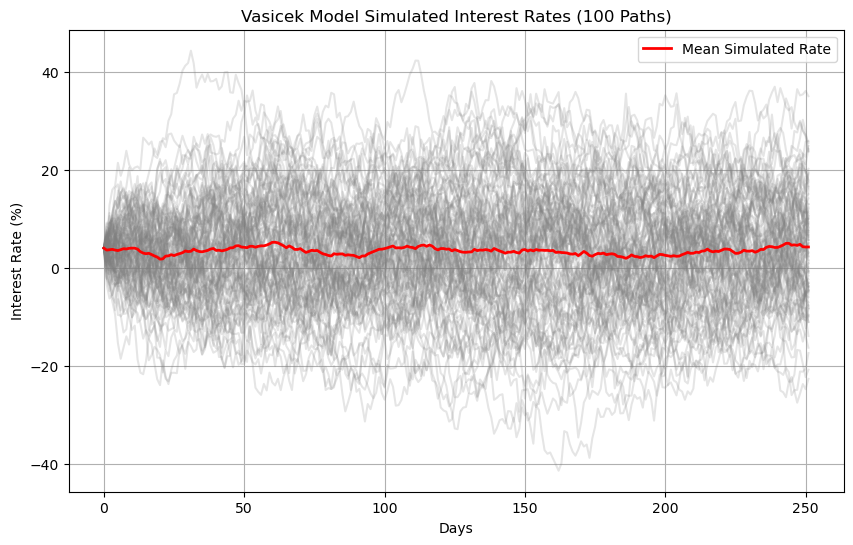

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.optimize import minimize
from datetime import datetime

# Step 1: Download interest rate data (10-year Treasury yield from FRED)
start = datetime(2000, 1, 1)
end = datetime(2024, 1, 1)
data = web.DataReader('GS10', 'fred', start, end)

# Check if the data was downloaded successfully
if not data.empty:
    rates = data['GS10'].dropna()
    print("Data downloaded successfully.")
else:
    raise ValueError("Error: Data is missing or improperly formatted.")

# Step 2: Define the Vasicek model's log-likelihood function to estimate parameters
def vasicek_likelihood(params, rates):
    kappa, theta, sigma = params
    dt = 1 / 252  # Assume daily frequency (252 trading days per year)
    
    # Calculate the daily log returns (difference)
    dr = np.diff(rates)
    r = rates[:-1]
    
    # Likelihood for each step in the process
    log_likelihood = -np.sum(np.log(0.5 * np.pi * sigma**2 * dt)) - np.sum(
        (dr - kappa * (theta - r) * dt)**2 / (2 * sigma**2 * dt)
    )
    return -log_likelihood  # Minimize negative log-likelihood

# Step 3: Estimate the Vasicek model parameters (kappa, theta, sigma)
initial_guess = [0.1, np.mean(rates), 0.01]
result = minimize(vasicek_likelihood, initial_guess, args=(rates,))
kappa, theta, sigma = result.x

print(f"Estimated Parameters:")
print(f"Kappa (mean reversion speed): {kappa}")
print(f"Theta (long-term mean): {theta}")
print(f"Sigma (volatility): {sigma}")

# Step 4: Simulate multiple future interest rate paths using the fitted Vasicek model
def simulate_multiple_vasicek(r0, kappa, theta, sigma, T, N, num_paths):
    dt = T / N
    all_simulated_paths = np.zeros((num_paths, N))
    
    for j in range(num_paths):
        rates_sim = np.zeros(N)
        rates_sim[0] = r0
        for i in range(1, N):
            dr = kappa * (theta - rates_sim[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
            rates_sim[i] = rates_sim[i-1] + dr
        all_simulated_paths[j] = rates_sim
    
    return all_simulated_paths

# Simulate 100 paths for future 1-year interest rates (252 trading days)
num_paths = 100
r0 = rates[-1]  # Use the last observed rate as the starting point
simulated_paths = simulate_multiple_vasicek(r0, kappa, theta, sigma, T=1, N=252, num_paths=num_paths)

# Step 5: Plot the results (all paths and mean path)
plt.figure(figsize=(10, 6))

# Plot all the paths
for path in simulated_paths:
    plt.plot(np.arange(0, 252), path, color='gray', alpha=0.2)

# Plot the mean path
mean_path = simulated_paths.mean(axis=0)
plt.plot(np.arange(0, 252), mean_path, label='Mean Simulated Rate', color='red', linewidth=2)

plt.title('Vasicek Model Simulated Interest Rates (100 Paths)')
plt.xlabel('Days')
plt.ylabel('Interest Rate (%)')
plt.grid(True)
plt.legend()
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


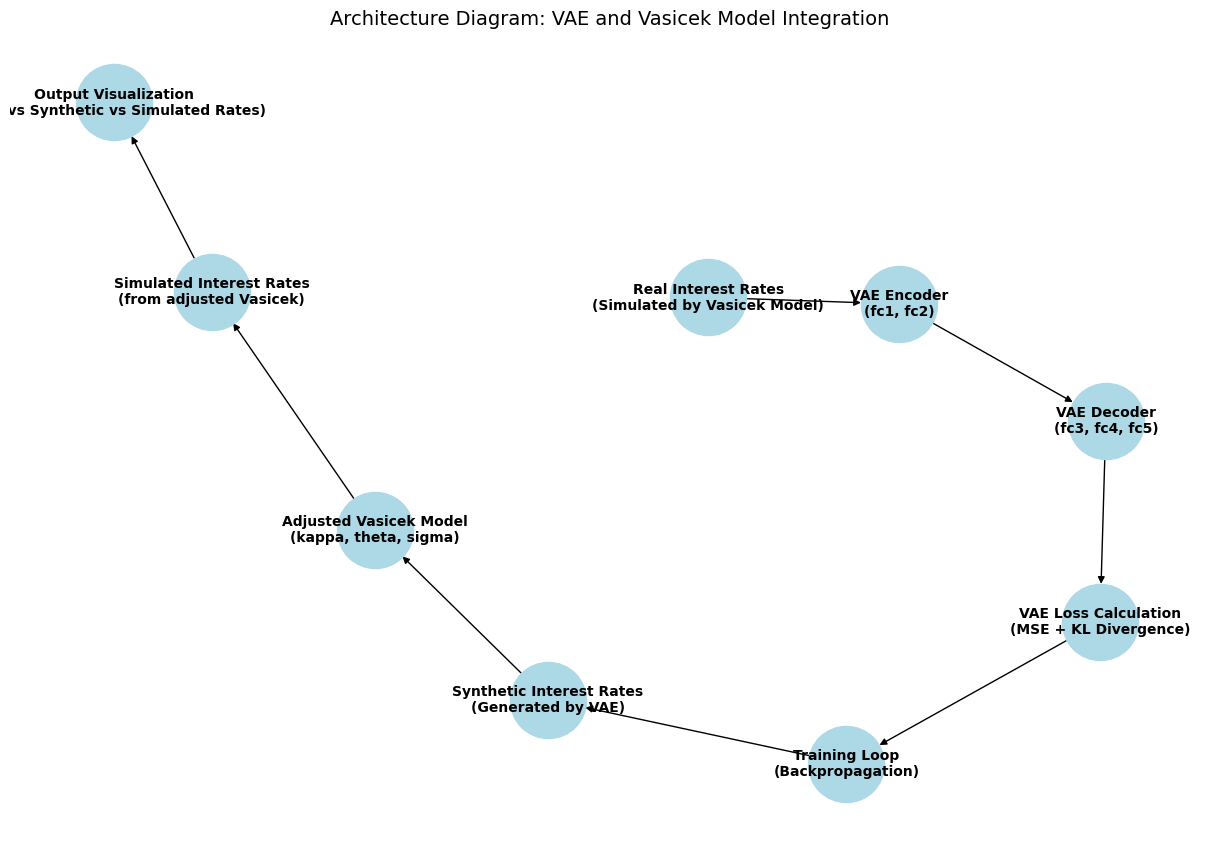

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes representing different parts of the architecture
G.add_node("Real Interest Rates\n(Simulated by Vasicek Model)")
G.add_node("VAE Encoder\n(fc1, fc2)")
G.add_node("VAE Decoder\n(fc3, fc4, fc5)")
G.add_node("VAE Loss Calculation\n(MSE + KL Divergence)")
G.add_node("Training Loop\n(Backpropagation)")
G.add_node("Synthetic Interest Rates\n(Generated by VAE)")
G.add_node("Adjusted Vasicek Model\n(kappa, theta, sigma)")
G.add_node("Simulated Interest Rates\n(from adjusted Vasicek)")
G.add_node("Output Visualization\n(Real vs Synthetic vs Simulated Rates)")

# Add edges to represent flow between nodes
G.add_edges_from([
    ("Real Interest Rates\n(Simulated by Vasicek Model)", "VAE Encoder\n(fc1, fc2)"),
    ("VAE Encoder\n(fc1, fc2)", "VAE Decoder\n(fc3, fc4, fc5)"),
    ("VAE Decoder\n(fc3, fc4, fc5)", "VAE Loss Calculation\n(MSE + KL Divergence)"),
    ("VAE Loss Calculation\n(MSE + KL Divergence)", "Training Loop\n(Backpropagation)"),
    ("Training Loop\n(Backpropagation)", "Synthetic Interest Rates\n(Generated by VAE)"),
    ("Synthetic Interest Rates\n(Generated by VAE)", "Adjusted Vasicek Model\n(kappa, theta, sigma)"),
    ("Adjusted Vasicek Model\n(kappa, theta, sigma)", "Simulated Interest Rates\n(from adjusted Vasicek)"),
    ("Simulated Interest Rates\n(from adjusted Vasicek)", "Output Visualization\n(Real vs Synthetic vs Simulated Rates)")
])

# Create a layout for the graph
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title("Architecture Diagram: VAE and Vasicek Model Integration", fontsize=14)
plt.show()


Graph saved as citation_relationship_20250127_212715.png


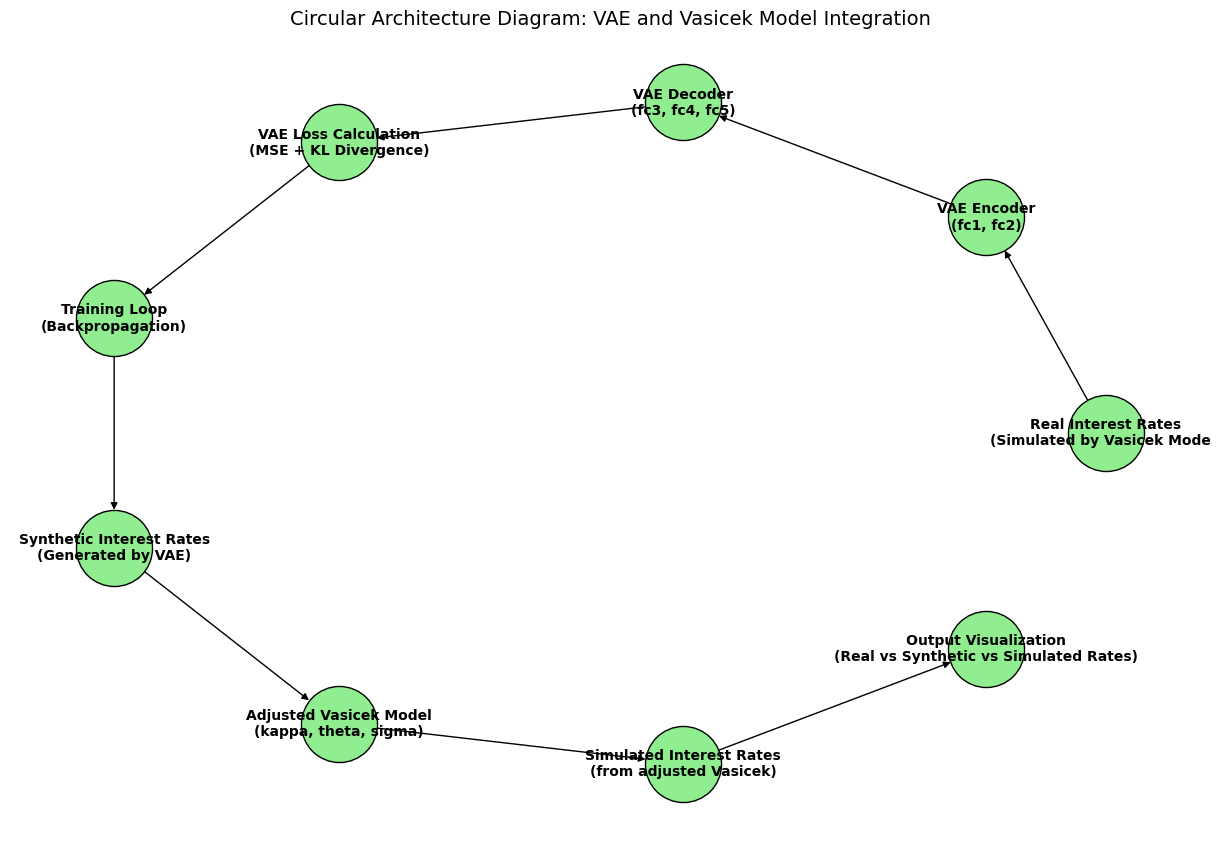

In [69]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Real Interest Rates\n(Simulated by Vasicek Model)")
G.add_node("VAE Encoder\n(fc1, fc2)")
G.add_node("VAE Decoder\n(fc3, fc4, fc5)")
G.add_node("VAE Loss Calculation\n(MSE + KL Divergence)")
G.add_node("Training Loop\n(Backpropagation)")
G.add_node("Synthetic Interest Rates\n(Generated by VAE)")
G.add_node("Adjusted Vasicek Model\n(kappa, theta, sigma)")
G.add_node("Simulated Interest Rates\n(from adjusted Vasicek)")
G.add_node("Output Visualization\n(Real vs Synthetic vs Simulated Rates)")

# Add edges
G.add_edges_from([
    ("Real Interest Rates\n(Simulated by Vasicek Model)", "VAE Encoder\n(fc1, fc2)"),
    ("VAE Encoder\n(fc1, fc2)", "VAE Decoder\n(fc3, fc4, fc5)"),
    ("VAE Decoder\n(fc3, fc4, fc5)", "VAE Loss Calculation\n(MSE + KL Divergence)"),
    ("VAE Loss Calculation\n(MSE + KL Divergence)", "Training Loop\n(Backpropagation)"),
    ("Training Loop\n(Backpropagation)", "Synthetic Interest Rates\n(Generated by VAE)"),
    ("Synthetic Interest Rates\n(Generated by VAE)", "Adjusted Vasicek Model\n(kappa, theta, sigma)"),
    ("Adjusted Vasicek Model\n(kappa, theta, sigma)", "Simulated Interest Rates\n(from adjusted Vasicek)"),
    ("Simulated Interest Rates\n(from adjusted Vasicek)", "Output Visualization\n(Real vs Synthetic vs Simulated Rates)")
])

# Circular layout
pos = nx.circular_layout(G)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', arrows=True, edgecolors='black')
plt.title("Circular Architecture Diagram: VAE and Vasicek Model Integration", fontsize=14)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


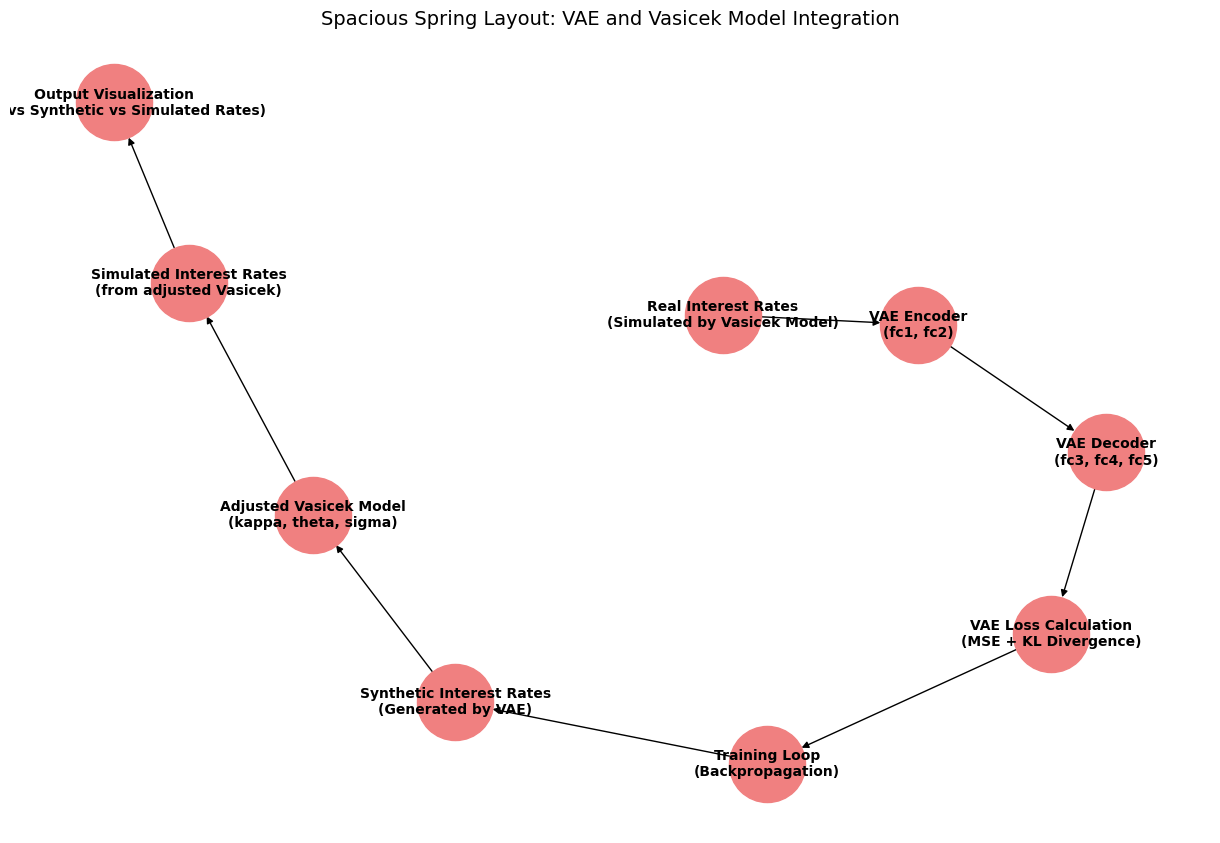

In [50]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
G.add_node("Real Interest Rates\n(Simulated by Vasicek Model)")
G.add_node("VAE Encoder\n(fc1, fc2)")
G.add_node("VAE Decoder\n(fc3, fc4, fc5)")
G.add_node("VAE Loss Calculation\n(MSE + KL Divergence)")
G.add_node("Training Loop\n(Backpropagation)")
G.add_node("Synthetic Interest Rates\n(Generated by VAE)")
G.add_node("Adjusted Vasicek Model\n(kappa, theta, sigma)")
G.add_node("Simulated Interest Rates\n(from adjusted Vasicek)")
G.add_node("Output Visualization\n(Real vs Synthetic vs Simulated Rates)")

G.add_edges_from([
    ("Real Interest Rates\n(Simulated by Vasicek Model)", "VAE Encoder\n(fc1, fc2)"),
    ("VAE Encoder\n(fc1, fc2)", "VAE Decoder\n(fc3, fc4, fc5)"),
    ("VAE Decoder\n(fc3, fc4, fc5)", "VAE Loss Calculation\n(MSE + KL Divergence)"),
    ("VAE Loss Calculation\n(MSE + KL Divergence)", "Training Loop\n(Backpropagation)"),
    ("Training Loop\n(Backpropagation)", "Synthetic Interest Rates\n(Generated by VAE)"),
    ("Synthetic Interest Rates\n(Generated by VAE)", "Adjusted Vasicek Model\n(kappa, theta, sigma)"),
    ("Adjusted Vasicek Model\n(kappa, theta, sigma)", "Simulated Interest Rates\n(from adjusted Vasicek)"),
    ("Simulated Interest Rates\n(from adjusted Vasicek)", "Output Visualization\n(Real vs Synthetic vs Simulated Rates)")
])

# Spring layout with more spacing
pos = nx.spring_layout(G, seed=42, k=0.3)  # k controls the spacing

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightcoral', font_size=10, font_weight='bold', arrows=True)
plt.title("Spacious Spring Layout: VAE and Vasicek Model Integration", fontsize=14)
plt.show()


Graph saved as citation_relationship_20250127_212725.png


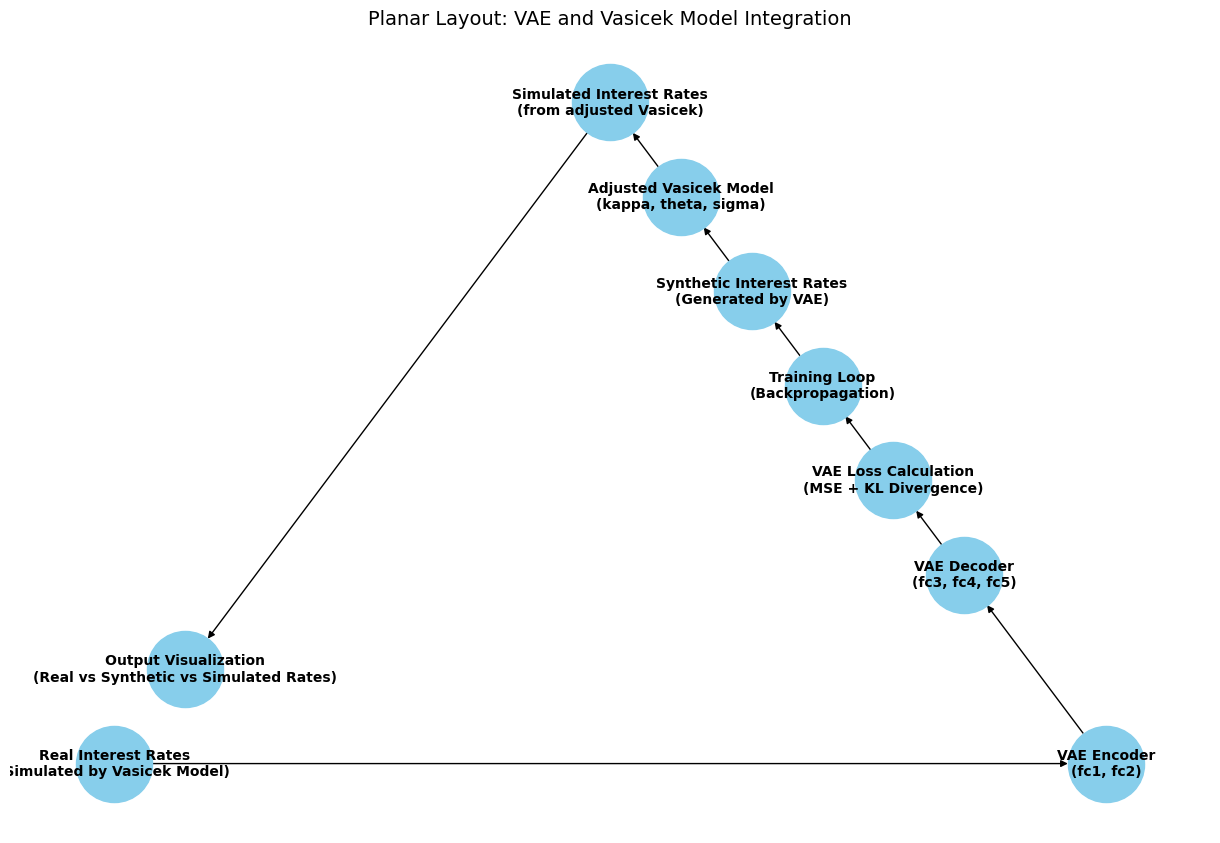

In [70]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
G.add_node("Real Interest Rates\n(Simulated by Vasicek Model)")
G.add_node("VAE Encoder\n(fc1, fc2)")
G.add_node("VAE Decoder\n(fc3, fc4, fc5)")
G.add_node("VAE Loss Calculation\n(MSE + KL Divergence)")
G.add_node("Training Loop\n(Backpropagation)")
G.add_node("Synthetic Interest Rates\n(Generated by VAE)")
G.add_node("Adjusted Vasicek Model\n(kappa, theta, sigma)")
G.add_node("Simulated Interest Rates\n(from adjusted Vasicek)")
G.add_node("Output Visualization\n(Real vs Synthetic vs Simulated Rates)")

G.add_edges_from([
    ("Real Interest Rates\n(Simulated by Vasicek Model)", "VAE Encoder\n(fc1, fc2)"),
    ("VAE Encoder\n(fc1, fc2)", "VAE Decoder\n(fc3, fc4, fc5)"),
    ("VAE Decoder\n(fc3, fc4, fc5)", "VAE Loss Calculation\n(MSE + KL Divergence)"),
    ("VAE Loss Calculation\n(MSE + KL Divergence)", "Training Loop\n(Backpropagation)"),
    ("Training Loop\n(Backpropagation)", "Synthetic Interest Rates\n(Generated by VAE)"),
    ("Synthetic Interest Rates\n(Generated by VAE)", "Adjusted Vasicek Model\n(kappa, theta, sigma)"),
    ("Adjusted Vasicek Model\n(kappa, theta, sigma)", "Simulated Interest Rates\n(from adjusted Vasicek)"),
    ("Simulated Interest Rates\n(from adjusted Vasicek)", "Output Visualization\n(Real vs Synthetic vs Simulated Rates)")
])

# Planar layout (horizontal positioning)
pos = nx.planar_layout(G)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
plt.title("Planar Layout: VAE and Vasicek Model Integration", fontsize=14)
import time

# Generate a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")

# Save the plot with a timestamp in the filename
filename = f"citation_relationship_{timestamp}.png"
plt.savefig(filename)

# Optionally, you can print the filename for reference
print(f"Graph saved as {filename}")
plt.show()


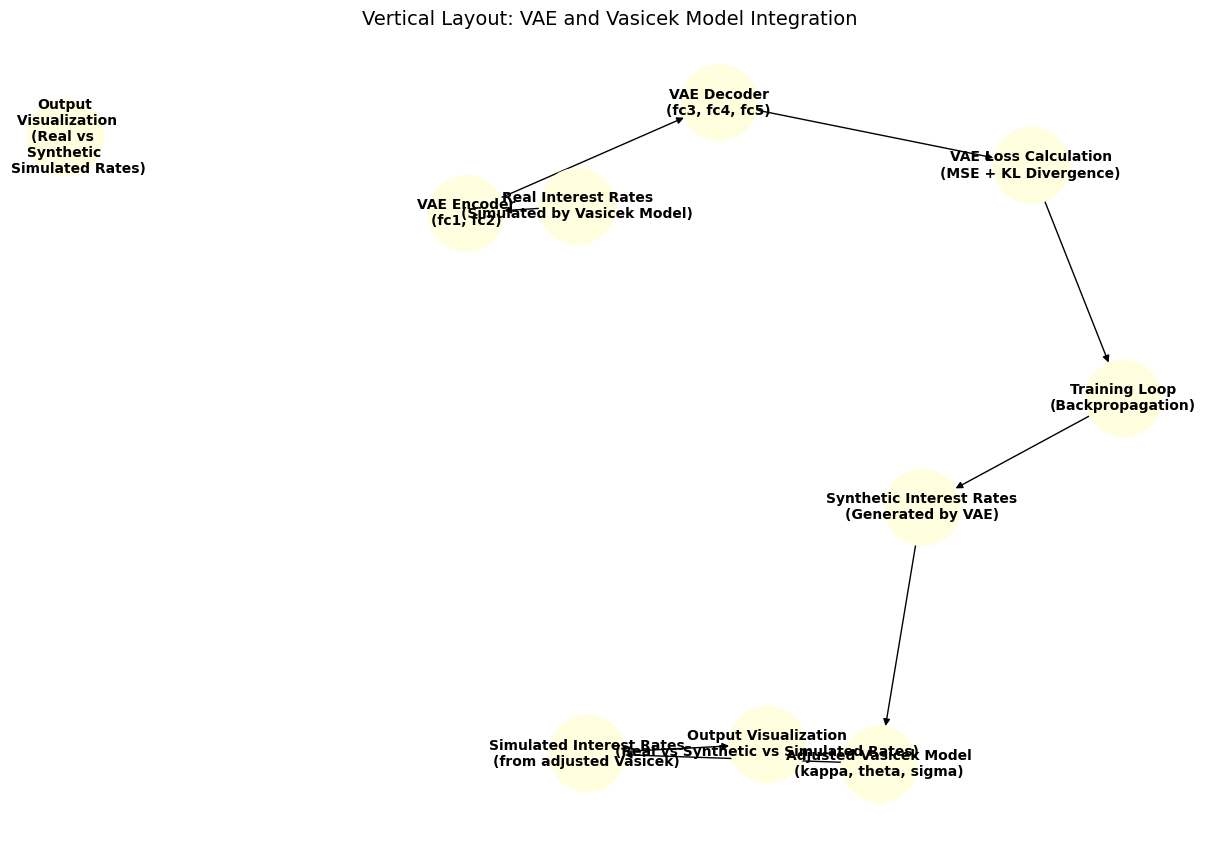

In [46]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
G.add_node("Real Interest Rates\n(Simulated by Vasicek Model)")
G.add_node("VAE Encoder\n(fc1, fc2)")
G.add_node("VAE Decoder\n(fc3, fc4, fc5)")
G.add_node("VAE Loss Calculation\n(MSE + KL Divergence)")
G.add_node("Training Loop\n(Backpropagation)")
G.add_node("Synthetic Interest Rates\n(Generated by VAE)")
G.add_node("Adjusted Vasicek Model\n(kappa, theta, sigma)")
G.add_node("Simulated Interest Rates\n(from adjusted Vasicek)")
G.add_node("Output\n Visualization\n(Real vs \n Synthetic \n vs Simulated Rates)")

G.add_edges_from([
    ("Real Interest Rates\n(Simulated by Vasicek Model)", "VAE Encoder\n(fc1, fc2)"),
    ("VAE Encoder\n(fc1, fc2)", "VAE Decoder\n(fc3, fc4, fc5)"),
    ("VAE Decoder\n(fc3, fc4, fc5)", "VAE Loss Calculation\n(MSE + KL Divergence)"),
    ("VAE Loss Calculation\n(MSE + KL Divergence)", "Training Loop\n(Backpropagation)"),
    ("Training Loop\n(Backpropagation)", "Synthetic Interest Rates\n(Generated by VAE)"),
    ("Synthetic Interest Rates\n(Generated by VAE)", "Adjusted Vasicek Model\n(kappa, theta, sigma)"),
    ("Adjusted Vasicek Model\n(kappa, theta, sigma)", "Simulated Interest Rates\n(from adjusted Vasicek)"),
    ("Simulated Interest Rates\n(from adjusted Vasicek)", "Output Visualization\n(Real vs Synthetic vs Simulated Rates)")
])

# Vertical layout
pos = nx.spring_layout(G, seed=42, k=0.5)  # Controls the vertical stretch

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightyellow', font_size=10, font_weight='bold', arrows=True)
plt.title("Vertical Layout: VAE and Vasicek Model Integration", fontsize=14)
plt.show()


In [56]:
import pygraphviz as pgv

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Simulate Interest Rate Data', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('VAE Encoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('VAE Decoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Loss Function', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Training Loop', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Generate Synthetic Data', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Simulate with Adjusted Volatility', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Plot Real vs Simulated', shape='box', style='filled', fillcolor='lightgray')

# Add edges between the nodes to represent flow
graph.add_edge('Simulate Interest Rate Data', 'VAE Encoder')
graph.add_edge('VAE Encoder', 'VAE Decoder')
graph.add_edge('VAE Decoder', 'Loss Function')
graph.add_edge('Loss Function', 'Training Loop')
graph.add_edge('Training Loop', 'Generate Synthetic Data')
graph.add_edge('Generate Synthetic Data', 'Simulate with Adjusted Volatility')
graph.add_edge('Simulate with Adjusted Volatility', 'Plot Real vs Simulated')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('vae_model_architecture.png')

# Display the image in the notebook
from PIL import Image
img = Image.open('vae_model_architecture.png')
img.show()


In [55]:
 # !pip install pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp312-cp312-linux_x86_64.whl size=98584 sha256=196ad62a85cb6c084f4df6c6d7d1db7257d31fd5dd439c5c8eefcb40e180a610
  Stored in directory: /home/j/.cache/pip/wheels/e1/2f/c3/0f7719eda975973b474b79b98e1208e635565c1e4dac777ac8
Successfully built pygraphviz


In [57]:
import pygraphviz as pgv
from PIL import Image

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Simulate Interest Rate Data', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('VAE Encoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('VAE Decoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Loss Function', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Training Loop', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Generate Synthetic Data', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Simulate with Adjusted Volatility', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Plot Real vs Simulated', shape='box', style='filled', fillcolor='lightgray')

# Add edges between the nodes to represent flow
graph.add_edge('Simulate Interest Rate Data', 'VAE Encoder')
graph.add_edge('VAE Encoder', 'VAE Decoder')
graph.add_edge('VAE Decoder', 'Loss Function')
graph.add_edge('Loss Function', 'Training Loop')
graph.add_edge('Training Loop', 'Generate Synthetic Data')
graph.add_edge('Generate Synthetic Data', 'Simulate with Adjusted Volatility')
graph.add_edge('Simulate with Adjusted Volatility', 'Plot Real vs Simulated')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('vae_model_architecture.png')

# Display the image in the notebook
img = Image.open('vae_model_architecture.png')
img.show()


In [58]:
import pygraphviz as pgv
from PIL import Image

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Simulate Interest Rate Data', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('Volatility Generator (GAN)', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Volatility Discriminator (GAN)', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Loss Function', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Training Loop', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Generate Synthetic Volatility', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Simulate with GAN-Generated Volatility', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Plot Real vs Simulated', shape='box', style='filled', fillcolor='lightgray')

# Add edges between the nodes to represent flow
graph.add_edge('Simulate Interest Rate Data', 'Volatility Generator (GAN)')
graph.add_edge('Volatility Generator (GAN)', 'Volatility Discriminator (GAN)')
graph.add_edge('Volatility Discriminator (GAN)', 'Loss Function')
graph.add_edge('Loss Function', 'Training Loop')
graph.add_edge('Training Loop', 'Generate Synthetic Volatility')
graph.add_edge('Generate Synthetic Volatility', 'Simulate with GAN-Generated Volatility')
graph.add_edge('Simulate with GAN-Generated Volatility', 'Plot Real vs Simulated')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('gan_volatility_model_architecture.png')

# Display the image in the notebook
img = Image.open('gan_volatility_model_architecture.png')
img.show()


In [59]:
import pygraphviz as pgv
from PIL import Image

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Simulate Interest Rate Data (Vasicek)', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('Volatility Generator (GAN)', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Volatility Discriminator (GAN)', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Loss Function', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Training Loop', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Generate Synthetic Volatility', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Simulate Interest Rates with GAN-Generated Volatility', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Plot Real vs Simulated Rates', shape='box', style='filled', fillcolor='lightgray')

# Add edges between the nodes to represent flow
graph.add_edge('Simulate Interest Rate Data (Vasicek)', 'Volatility Generator (GAN)')
graph.add_edge('Volatility Generator (GAN)', 'Volatility Discriminator (GAN)')
graph.add_edge('Volatility Discriminator (GAN)', 'Loss Function')
graph.add_edge('Loss Function', 'Training Loop')
graph.add_edge('Training Loop', 'Generate Synthetic Volatility')
graph.add_edge('Generate Synthetic Volatility', 'Simulate Interest Rates with GAN-Generated Volatility')
graph.add_edge('Simulate Interest Rates with GAN-Generated Volatility', 'Plot Real vs Simulated Rates')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('gan_volatility_in_vasicek_model_architecture.png')

# Display the image in the notebook
img = Image.open('gan_volatility_in_vasicek_model_architecture.png')
img.show()


In [60]:
import pygraphviz as pgv
from PIL import Image

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Simulate Interest Rate Data (Vasicek)', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('VAE Encoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('VAE Decoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Loss Function', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Training Loop', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Generate Synthetic Data', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Adjust Vasicek Parameters with VAE', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Simulate Interest Rates with Adjusted Parameters', shape='box', style='filled', fillcolor='lightgray')
graph.add_node('Plot Real vs Simulated Rates', shape='box', style='filled', fillcolor='lightgray')

# Add edges between the nodes to represent flow
graph.add_edge('Simulate Interest Rate Data (Vasicek)', 'VAE Encoder')
graph.add_edge('VAE Encoder', 'VAE Decoder')
graph.add_edge('VAE Decoder', 'Loss Function')
graph.add_edge('Loss Function', 'Training Loop')
graph.add_edge('Training Loop', 'Generate Synthetic Data')
graph.add_edge('Generate Synthetic Data', 'Adjust Vasicek Parameters with VAE')
graph.add_edge('Adjust Vasicek Parameters with VAE', 'Simulate Interest Rates with Adjusted Parameters')
graph.add_edge('Simulate Interest Rates with Adjusted Parameters', 'Plot Real vs Simulated Rates')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('vae_and_vasicek_model_architecture.png')

# Display the image in the notebook
img = Image.open('vae_and_vasicek_model_architecture.png')
img.show()


In [61]:
import pygraphviz as pgv

# Create a new directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Add nodes for each component
graph.add_node('Generate Synthetic Interest Rates', shape='box', style='filled', fillcolor='lightblue')
graph.add_node('VAE Encoder', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('GAN Generator', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Monte Carlo Simulation', shape='box', style='filled', fillcolor='lightgreen')
graph.add_node('Compare Models (VAE, GAN, Monte Carlo)', shape='box', style='filled', fillcolor='lightyellow')
graph.add_node('Query Public Data via ChatGPT', shape='box', style='filled', fillcolor='lightcoral')
graph.add_node('Adjust Vasicek Parameters', shape='box', style='filled', fillcolor='lightpink')
graph.add_node('Simulate Future Rates (Vasicek)', shape='box', style='filled', fillcolor='lightcyan')
graph.add_node('Align Outputs with Real Data', shape='box', style='filled', fillcolor='lightgray')
graph.add_node('Visualize Real vs Synthetic Data', shape='box', style='filled', fillcolor='lightgoldenrodyellow')

# Add edges to represent the flow
graph.add_edge('Generate Synthetic Interest Rates', 'VAE Encoder')
graph.add_edge('Generate Synthetic Interest Rates', 'GAN Generator')
graph.add_edge('Generate Synthetic Interest Rates', 'Monte Carlo Simulation')
graph.add_edge('VAE Encoder', 'Compare Models (VAE, GAN, Monte Carlo)')
graph.add_edge('GAN Generator', 'Compare Models (VAE, GAN, Monte Carlo)')
graph.add_edge('Monte Carlo Simulation', 'Compare Models (VAE, GAN, Monte Carlo)')
graph.add_edge('Compare Models (VAE, GAN, Monte Carlo)', 'Query Public Data via ChatGPT')
graph.add_edge('Query Public Data via ChatGPT', 'Adjust Vasicek Parameters')
graph.add_edge('Adjust Vasicek Parameters', 'Simulate Future Rates (Vasicek)')
graph.add_edge('Simulate Future Rates (Vasicek)', 'Align Outputs with Real Data')
graph.add_edge('Align Outputs with Real Data', 'Visualize Real vs Synthetic Data')

# Render and view the graph
graph.layout(prog='dot')
graph.draw('synthetic_interest_rate_model.png')

# Display the image in the notebook
from PIL import Image
img = Image.open('synthetic_interest_rate_model.png')
img.show()
